# 7. **picoGPT**: implementing a tiny **GPT** from scratch

In [1]:
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    print("Cloning repo...")
    !git clone --quiet https://github.com/ckaraneen/micrograduate.git > /dev/null
    %cd micrograduate
    print("Installing requirements...")
    !pip install --quiet uv
    !uv pip install --system --quiet -r requirements.txt

## Intro

In this lesson, we'll implement a tiny **GPT** from scratch in just a few lines of NumPy. To keep things simple, we'll then load the trained **GPT**-2 model weights released by OpenAI into our implementation and generate some text. Sounds straightforward, right? Well, that's because it is! Let's get started.

## What is a **GPT**?

**GPT** stands for *Generative Pre-trained Transformer*. It's a type of **nn** architecture based on the [Transformer](https://arxiv.org/pdf/1706.03762.pdf). [Jay Alammar's How **GPT**3 Works](https://jalammar.github.io/how-gpt3-works-visualizations-animations/) is an excellent introduction to **GPT**s at a high level, but here's the tl;dr:
- Generative: A **GPT** generates text.
- Pre-trained: A **GPT** is trained on lots of text from books, the internet, etc ...
- Transformer: A **GPT** is a decoder-only transformer **nn**.

Large Language Models (LLMs), like [OpenAI's **GPT**-3](https://en.wikipedia.org/wiki/GPT-3), are just **GPT**s under the hood. What makes them special is they happen to be:
1. very big (billions of parameters) and
2. trained on lots of data (hundreds of gigabytes of text).

Fundamentally, a **GPT** generates text given a prompt. Even with this very simple API (input = text, output = text), a well-trained **GPT** can do some pretty awesome stuff like [write your emails](https://machinelearningknowledge.ai/ezoimgfmt/b2611031.smushcdn.com/2611031/wp-content/uploads/2022/12/ChatGPT-Demo-of-Drafting-an-Email.png?lossy=0&strip=1&webp=1&ezimgfmt=ng:webp/ngcb1), [summarize a book](https://machinelearningknowledge.ai/ezoimgfmt/b2611031.smushcdn.com/2611031/wp-content/uploads/2022/12/ChatGPT-Example-Book-Summarization.png?lossy=0&strip=1&webp=1&ezimgfmt=ng:webp/ngcb1), [give you instagram caption ideas](https://khrisdigital.com/wp-content/uploads/2022/12/image-1.png), [explain black holes to a 5 year old](https://machinelearningknowledge.ai/ezoimgfmt/b2611031.smushcdn.com/2611031/wp-content/uploads/2022/12/ChatGPT-Examples-Explaining-Black-Holes.png?lossy=0&strip=1&webp=1&ezimgfmt=ng:webp/ngcb1), [code in SQL](https://machinelearningknowledge.ai/ezoimgfmt/b2611031.smushcdn.com/2611031/wp-content/uploads/2022/12/ChatGPT-Demo-of-Writing-SQL-Queries.png?lossy=0&strip=1&webp=1&ezimgfmt=ng:webp/ngcb1), and even [write your will](https://machinelearningknowledge.ai/ezoimgfmt/b2611031.smushcdn.com/2611031/wp-content/uploads/2022/12/Chat-GPT-Example-Writing-a-Will.png?lossy=0&strip=1&webp=1&ezimgfmt=ng:webp/ngcb1). So that's a high-level overview of **GPT**s and their capabilities. Let's dig into some more specifics.

### Input / Output

The function signature for a **GPT** looks roughly like this:

```python
def gpt(inputs: list[int]) -> list[list[float]]:
    # inputs has shape [n_seq]
    # output has shape [n_seq, n_vocab]
    output = # beep boop neural network magic
    return output
```

#### Input

The input is some text represented by a sequence of integers that map to tokens in the text:

```python
# integers represent tokens in our text, for example:
# text   = "not all heroes wear capes":
# tokens = "not"  "all" "heroes" "wear" "capes"
inputs =   [1,     0,    2,      4,     6]
```

Tokens are sub-pieces of the text, which are produced using some kind of tokenizer. We can map tokens to integers using a vocabulary:

```python
# the index of a token in the vocab represents the integer id for that token
# i.e. the integer id for "heroes" would be 2, since vocab[2] = "heroes"
vocab = ["all", "not", "heroes", "the", "wear", ".", "capes"]

# a pretend tokenizer that tokenizes on whitespace
tokenizer = WhitespaceTokenizer(vocab)

# the encode() method converts a str -> list[int]
ids = tokenizer.encode("not all heroes wear") # ids = [1, 0, 2, 4]

# we can see what the actual tokens are via our vocab mapping
tokens = [tokenizer.vocab[i] for i in ids] # tokens = ["not", "all", "heroes", "wear"]

# the decode() method converts back a list[int] -> str
text = tokenizer.decode(ids) # text = "not all heroes wear"
```

In short:
- We have a string.
- We use a tokenizer to break it down into smaller pieces called tokens.
- We use a vocabulary to map those tokens to integers.

In practice, we use more advanced methods of tokenization than simply splitting by whitespace, such as [Byte-Pair Encoding](https://huggingface.co/course/chapter6/5?fw=pt) or [WordPiece](https://huggingface.co/course/chapter6/6?fw=pt), but the principle is the same:

- There is a `vocab` that maps string tokens to integer indices
- There is an `encode` method that converts `str -> list[int]`
- There is a `decode` method that converts `list[int] -> str`

*Note*: For certain applications, the tokenizer doesn't require a decode method. For example, if you want to classify if a movie review is saying the movie was good or bad, you only need to be able to encode the text and do a forward pass of the model, there is no need for decode. For generating text however, decode is a requirement. ↩︎


#### Output

The output is a $2D$ array, where `output[i][j]` is the model's predicted probability that the token at `vocab[j]` is the next token `inputs[i+1]`. For example:

```python
vocab = ["all", "not", "heroes", "the", "wear", ".", "capes"]
inputs = [1, 0, 2, 4] # "not" "all" "heroes" "wear"
output = gpt(inputs)
#              ["all", "not", "heroes", "the", "wear", ".", "capes"]
# output[0] =  [0.75    0.1     0.0       0.15    0.0   0.0    0.0  ]
# given just "not", the model predicts the word "all" with the highest probability

#              ["all", "not", "heroes", "the", "wear", ".", "capes"]
# output[1] =  [0.0     0.0      0.8     0.1    0.0    0.0   0.1  ]
# given the sequence ["not", "all"], the model predicts the word "heroes" with the highest probability

#              ["all", "not", "heroes", "the", "wear", ".", "capes"]
# output[-1] = [0.0     0.0     0.0     0.1     0.0    0.05  0.85  ]
# given the whole sequence ["not", "all", "heroes", "wear"], the model predicts the word "capes" with the highest probability
```

To get a next token prediction for the whole sequence, we simply take the token with the highest probability in `output[-1]`:


```python
vocab = ["all", "not", "heroes", "the", "wear", ".", "capes"]
inputs = [1, 0, 2, 4] # "not" "all" "heroes" "wear"
output = gpt(inputs)
next_token_id = np.argmax(output[-1]) # next_token_id = 6
next_token = vocab[next_token_id] # next_token = "capes"
```

Taking the token with the highest probability as our prediction is known as [greedy decoding](https://docs.cohere.ai/docs/controlling-generation-with-top-k-top-p#1-pick-the-top-token-greedy-decoding) or greedy sampling. The task of predicting the next logical word in a sequence is called language modeling. As such, we can call a **GPT** a language model. Generating a single word is cool and all, but what about entire sentences, paragraphs, etc ...?

### Generating text

#### Autoregressive

We can generate full sentences by iteratively getting the next token prediction from our model. At each iteration, we append the predicted token back into the input:

```python
def generate(inputs, n_tokens_to_generate):
    for _ in range(n_tokens_to_generate): # auto-regressive decode loop
        output = gpt(inputs) # model forward pass
        next_id = np.argmax(output[-1]) # greedy sampling
        inputs.append(int(next_id)) # append prediction to input
    return inputs[len(inputs) - n_tokens_to_generate :]  # only return generated ids

input_ids = [1, 0] # "not" "all"
output_ids = generate(input_ids, 3) # output_ids = [2, 4, 6]
output_tokens = [vocab[i] for i in output_ids] # "heroes" "wear" "capes"
```

This process of predicting a future value (regression), and adding it back into the input (auto), is why you might see a **GPT** described as autoregressive.

#### Sampling

We can introduce some stochasticity (randomness) to our generations by sampling from the probability distribution instead of being greedy:

```python
inputs = [1, 0, 2, 4] # "not" "all" "heroes" "wear"
output = gpt(inputs)
np.random.choice(np.arange(vocab_size), p=output[-1]) # capes
np.random.choice(np.arange(vocab_size), p=output[-1]) # hats
np.random.choice(np.arange(vocab_size), p=output[-1]) # capes
np.random.choice(np.arange(vocab_size), p=output[-1]) # capes
np.random.choice(np.arange(vocab_size), p=output[-1]) # pants
```

This allows us to generate different sentences given the same input. When combined with techniques like [top-k](https://docs.cohere.ai/docs/controlling-generation-with-top-k-top-p#2-pick-from-amongst-the-top-tokens-top-k), [top-p](https://docs.cohere.ai/docs/controlling-generation-with-top-k-top-p#3-pick-from-amongst-the-top-tokens-whose-probabilities-add-up-to-15-top-p), and [temperature](https://docs.cohere.ai/docs/temperature), which modify the distribution prior to sampling, the quality of our outputs is greatly increased. These techniques also introduce some hyperparameters that we can play around with to get different generation behaviors (for example, increasing temperature makes our model take more risks and thus be more "creative".

### Training

We train a **GPT** like any other **nn**, using gradient descent **w.r.t.** some **loss** function. In the case of a **GPT**, we take the cross entropy **loss** over the language modeling task:

```python
def lm_loss(inputs: list[int], params) -> float:
    # the labels y are just the input shifted 1 to the left
    #
    # inputs = [not,     all,   heros,   wear,   capes]
    #      x = [not,     all,   heroes,  wear]
    #      y = [all,  heroes,     wear,  capes]
    #
    # of course, we don't have a label for inputs[-1], so we exclude it from x
    #
    # as such, for N inputs, we have N - 1 language modeling example pairs
    x, y = inputs[:-1], inputs[1:] # both have shape [num_tokens_in_seq - 1]

    # forward pass
    # all the predicted next token probability distributions at each position
    output = gpt(x, params) # has shape [num_tokens_in_seq - 1, num_tokens_in_vocab]

    # cross entropy loss
    # we take the average over all N-1 examples
    loss = np.mean(-np.log(output[np.arange(len(output)), y]))

    return loss

def train(texts: list[list[str]], params) -> float:
    for text in texts:
        inputs = tokenizer.encode(text)
        loss = lm_loss(inputs, params)
        gradients = compute_gradients_via_backpropagation(loss, params)
        params = gradient_descent_update_step(gradients, params)
    return params
```

This is a heavily simplified training setup, but it illustrates the point. Notice the addition of `params` to our `gpt` function signature (we left this out in the previous sections for simplicity). During each iteration of the training loop:

1. We compute the language modeling **loss** for the given input text example
2. The **loss** determines our gradients, which we compute via **backprop**
3. We use the gradients to update our model parameters such that the **loss** is minimized (gradient descent)

Notice, we don't use explicitly labelled data. Instead, we are able to produce the input/label pairs from just the raw text itself. This is referred to as [self-supervised learning](https://en.wikipedia.org/wiki/Self-supervised_learning). Self-supervision enables us to massively scale training data. Just get our hands on as much raw text as possible and throw it at the model. For example, **GPT**-3 was trained on 300 billion tokens of text from the internet and books:

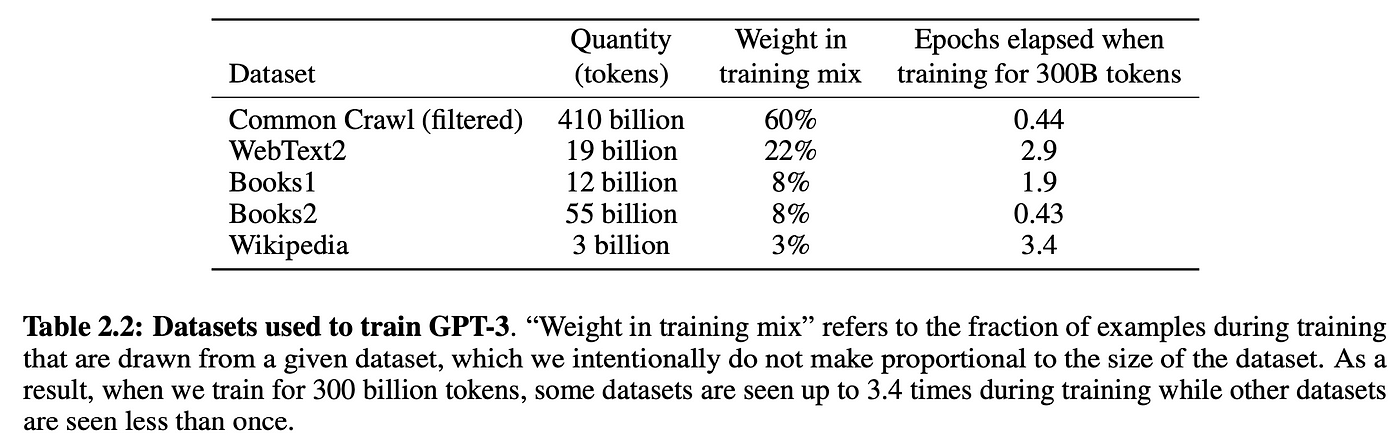

In [2]:
from IPython.display import Image, display

display(Image(filename="table_2.2_gpt3_paper.png"))

Of course, you need a sufficiently large model to be able to learn from all this data, which is why **GPT**-3 has 175 billion parameters and probably cost between [$1m-10m in compute cost to train](https://twitter.com/eturner303/status/1266264358771757057). This self-supervised training step is called pre-training, since we can reuse the "pre-trained" models weights to further train the model on downstream tasks, such as classifying if a tweet is toxic or not. Pre-trained models are also sometimes called foundation models. Training the model on downstream tasks is called fine-tuning, since the model weights have already been pre-trained to understand language, it's just being fine-tuned to the specific task at hand. The "pre-training on a general task + fine-tuning on a specific task" strategy is called [transfer learning](https://en.wikipedia.org/wiki/Transfer_learning).

*Note*: Although, with the [InstructGPT](https://arxiv.org/pdf/2210.11416.pdf) and [Chinchilla](https://arxiv.org/pdf/2203.15556.pdf) papers, we've realized that we don't actually need to train models that big. An optimally trained and instruction fine-tuned **GPT** at 1.3B parameters can outperform **GPT**-3 at 175B parameters.

### Prompting

In principle, the original [**GPT**](https://s3-us-west-2.amazonaws.com/openai-assets/research-covers/language-unsupervised/language_understanding_paper.pdf) paper was only about the benefits of pre-training a transformer model for transfer learning. The paper showed that pre-training a 117M **GPT** achieved state-of-the-art performance on various NLP (natural language processing) tasks when fine-tuned on labelled datasets. It wasn't until the [**GPT**-2](https://d4mucfpksywv.cloudfront.net/better-language-models/language_models_are_unsupervised_multitask_learners.pdf) and [**GPT**-3](https://arxiv.org/abs/2005.14165) papers that we realized a **GPT** model pre-trained on enough data with enough parameters was capable of performing any arbitrary task by itself, no fine-tuning needed. Just prompt the model, perform autoregressive language modeling, and voila, the model magically gives us an appropriate response. This is referred to as in-context learning, because the model is using just the context of the prompt to perform the task. In-context learning can be zero shot, one shot, or few shot:

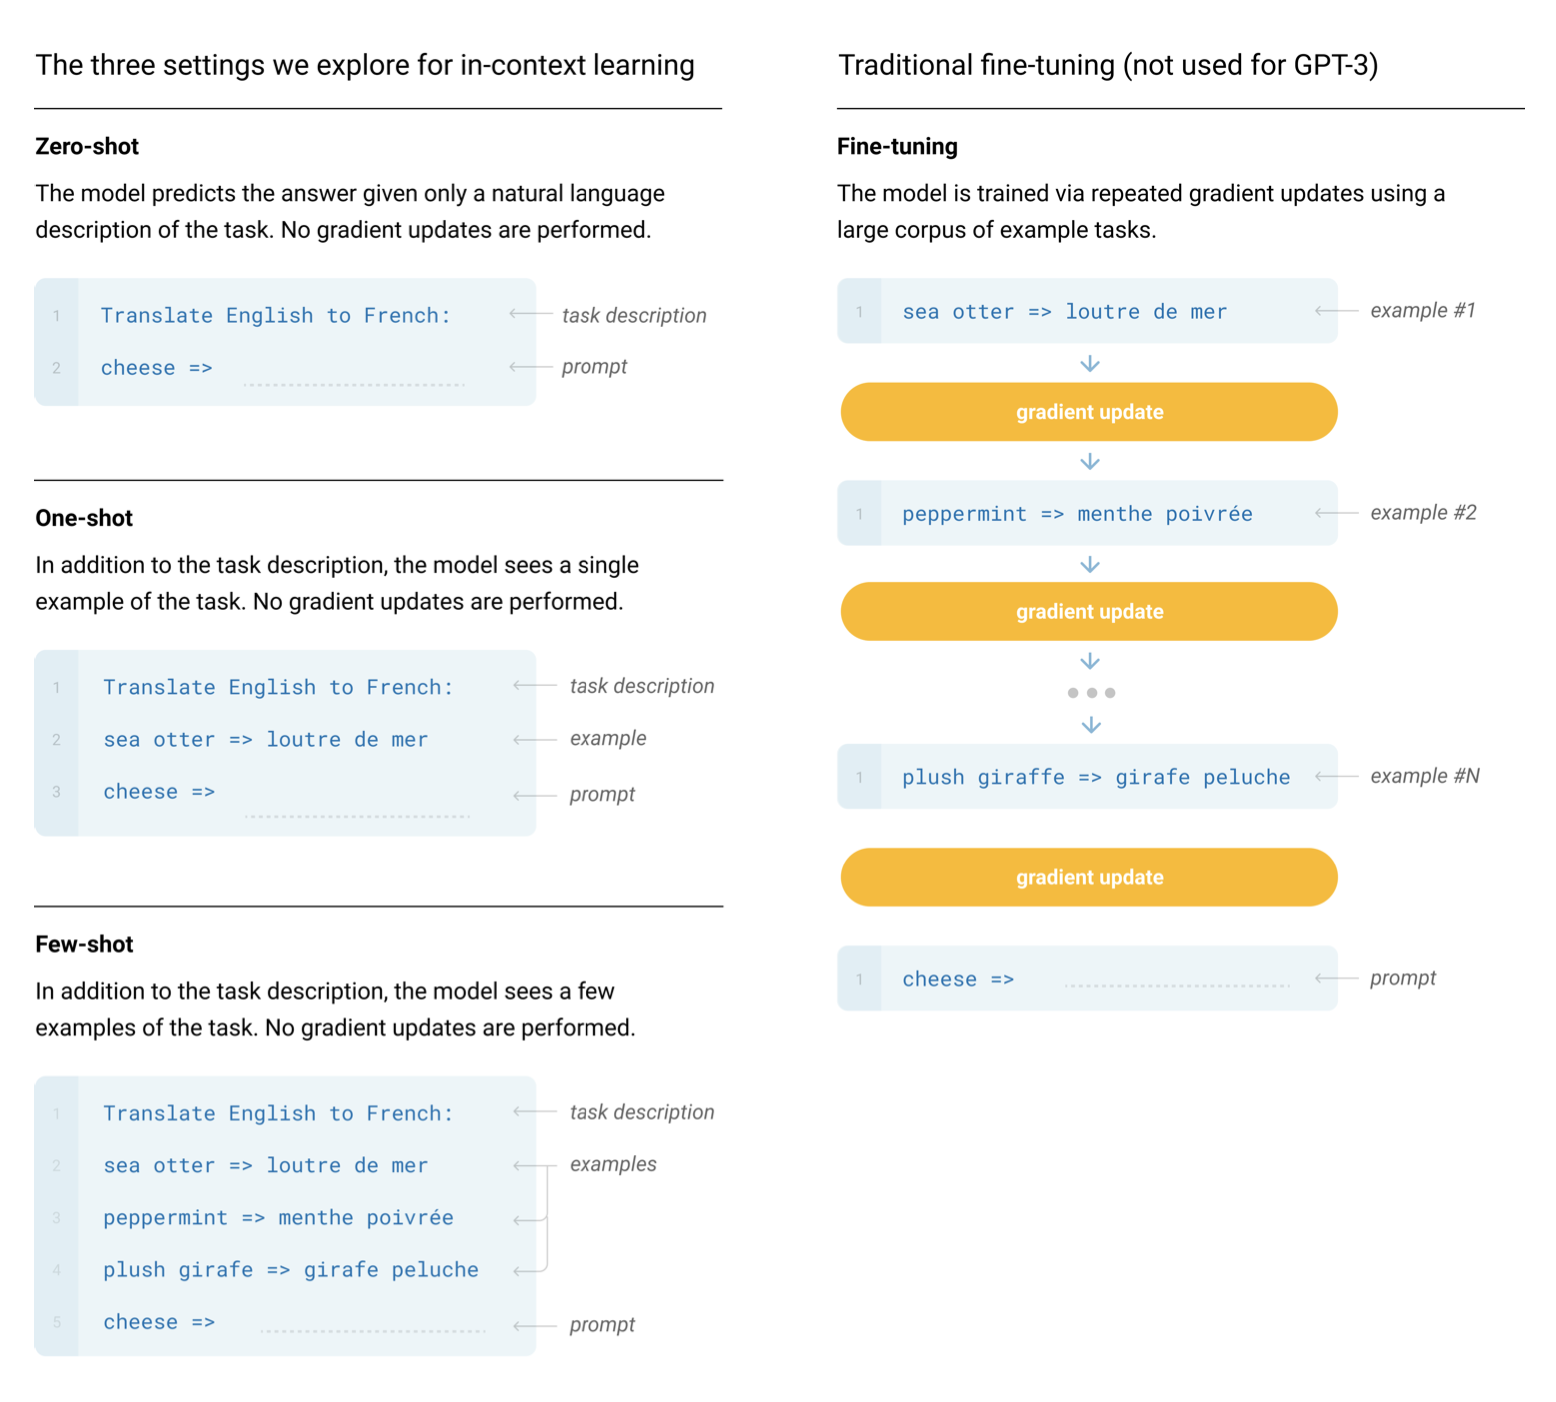

In [3]:
from IPython.display import Image, display

display(Image(filename="fig_2.1_gpt3_paper.png"))

Generating text given a prompt is also sometimes referred to as conditional generation, since our model is generating some output conditioned on some input. **GPT**s are not limited to NLP tasks. You can condition the model on anything you want. For example, you can turn a **GPT** into a chatbot (i.e. [Chat**GPT**](https://openai.com/index/chatgpt/)) by conditioning it on the conversation history. You can also further condition the chatbot to behave a certain way by prepending the prompt with some kind of description (i.e. "You are a chatbot. Be polite, speak in full sentences, don't say harmful things, etc ..."). Conditioning the model like this can even give your [chatbot a persona](https://imgur.com/a/AbDFcgk). This is often referred to as a system prompt. However, this is not robust, you can still ["jailbreak" the model and make it misbehave](https://twitter.com/zswitten/status/1598380220943593472). With that out of the way, let's finally get to the actual implementation.

## Setup

Let's dive right into the **GPT** implementation. First though, let's define the necessary functions for downloading the model of our choice and the tokenizer files for  loading `encoder`, `hparams`, and `params` into our code:

In [4]:
"""Byte pair encoding utilities.

Contains the code for OpenAI's BPE Tokenizer, taken straight from their gpt-2 repo: https://github.com/openai/gpt-2/blob/master/src/encoder.py.
"""

import json
import os
from functools import lru_cache
import regex as re


@lru_cache()
def bytes_to_unicode():
    """
    Returns list of utf-8 byte and a corresponding list of unicode strings.
    The reversible bpe codes work on unicode strings.
    This means you need a large # of unicode characters in your vocab if you want to avoid UNKs.
    When you're at something like a 10B token dataset you end up needing around 5K for decent coverage.
    This is a significant percentage of your normal, say, 32K bpe vocab.
    To avoid that, we want lookup tables between utf-8 bytes and unicode strings.
    And avoids mapping to whitespace/control characters the bpe code barfs on.
    """
    bs = (
        list(range(ord("!"), ord("~") + 1))
        + list(range(ord("¡"), ord("¬") + 1))
        + list(range(ord("®"), ord("ÿ") + 1))
    )
    cs = bs[:]
    n = 0
    for b in range(2**8):
        if b not in bs:
            bs.append(b)
            cs.append(2**8 + n)
            n += 1
    cs = [chr(n) for n in cs]
    return dict(zip(bs, cs))


def get_pairs(word):
    """Return set of symbol pairs in a word.
    Word is represented as tuple of symbols (symbols being variable-length strings).
    """
    pairs = set()
    prev_char = word[0]
    for char in word[1:]:
        pairs.add((prev_char, char))
        prev_char = char
    return pairs


class Encoder:
    def __init__(self, encoder, bpe_merges, errors="replace"):
        self.encoder = encoder
        self.decoder = {v: k for k, v in self.encoder.items()}
        self.errors = errors  # how to handle errors in decoding
        self.byte_encoder = bytes_to_unicode()
        self.byte_decoder = {v: k for k, v in self.byte_encoder.items()}
        self.bpe_ranks = dict(zip(bpe_merges, range(len(bpe_merges))))
        self.cache = {}

        # Should have added re.IGNORECASE so BPE merges can happen for capitalized versions of contractions
        self.pat = re.compile(
            r"""'s|'t|'re|'ve|'m|'ll|'d| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+"""
        )

    def bpe(self, token):
        if token in self.cache:
            return self.cache[token]
        word = tuple(token)
        pairs = get_pairs(word)

        if not pairs:
            return token

        while True:
            bigram = min(pairs, key=lambda pair: self.bpe_ranks.get(pair, float("inf")))
            if bigram not in self.bpe_ranks:
                break
            first, second = bigram
            new_word = []
            i = 0
            while i < len(word):
                try:
                    j = word.index(first, i)
                    new_word.extend(word[i:j])
                    i = j
                except:
                    new_word.extend(word[i:])
                    break

                if word[i] == first and i < len(word) - 1 and word[i + 1] == second:
                    new_word.append(first + second)
                    i += 2
                else:
                    new_word.append(word[i])
                    i += 1
            new_word = tuple(new_word)
            word = new_word
            if len(word) == 1:
                break
            else:
                pairs = get_pairs(word)
        word = " ".join(word)
        self.cache[token] = word
        return word

    def encode(self, text):
        bpe_tokens = []
        for token in re.findall(self.pat, text):
            token = "".join(self.byte_encoder[b] for b in token.encode("utf-8"))
            bpe_tokens.extend(
                self.encoder[bpe_token] for bpe_token in self.bpe(token).split(" ")
            )
        return bpe_tokens

    def decode(self, tokens):
        text = "".join([self.decoder[token] for token in tokens])
        text = bytearray([self.byte_decoder[c] for c in text]).decode(
            "utf-8", errors=self.errors
        )
        return text


def get_encoder(model_name, models_dir):
    with open(os.path.join(models_dir, model_name, "encoder.json"), "r") as f:
        encoder = json.load(f)
    with open(
        os.path.join(models_dir, model_name, "vocab.bpe"), "r", encoding="utf-8"
    ) as f:
        bpe_data = f.read()
    bpe_merges = [tuple(merge_str.split()) for merge_str in bpe_data.split("\n")[1:-1]]
    return Encoder(encoder=encoder, bpe_merges=bpe_merges)

In [5]:
"""GPT-2 utilities.

Contains the code to download and load the GPT-2 model weights, tokenizer, and hyperparameters.
"""

import json
import os
import requests
import tensorflow as tf
from tqdm import tqdm


def download_gpt2_files(model_size, model_dir):
    assert model_size in ["124M", "355M", "774M", "1558M"]
    for filename in [
        "checkpoint",
        "encoder.json",
        "hparams.json",
        "model.ckpt.data-00000-of-00001",
        "model.ckpt.index",
        "model.ckpt.meta",
        "vocab.bpe",
    ]:
        url = "https://openaipublic.blob.core.windows.net/gpt-2/models"
        r = requests.get(f"{url}/{model_size}/{filename}", stream=True)
        r.raise_for_status()

        with open(os.path.join(model_dir, filename), "wb") as f:
            file_size = int(r.headers["content-length"])
            chunk_size = 1000
            with tqdm(
                ncols=100,
                desc="Fetching " + filename,
                total=file_size,
                unit_scale=True,
            ) as pbar:
                # 1k for chunk_size, since Ethernet packet size is around 1500 bytes
                for chunk in r.iter_content(chunk_size=chunk_size):
                    f.write(chunk)
                    pbar.update(chunk_size)


def load_gpt2_params_from_tf_ckpt(tf_ckpt_path, hparams):
    import re
    import numpy as np

    def set_in_nested_dict(d, keys, val):
        if not keys:
            return val
        if keys[0] not in d:
            d[keys[0]] = {}
        d[keys[0]] = set_in_nested_dict(d[keys[0]], keys[1:], val)
        return d

    init_vars = tf.train.list_variables(tf_ckpt_path)
    params = {"blocks": [{} for _ in range(hparams["n_layer"])]}
    for name, _ in init_vars:
        array = np.squeeze(tf.train.load_variable(tf_ckpt_path, name))
        name = name.removeprefix("model/")
        if name.startswith("h"):
            m = re.match(r"h([0-9]+)/(.*)", name)
            n = int(m[1])
            sub_name = m[2]
            set_in_nested_dict(params["blocks"][n], sub_name.split("/"), array)
        else:
            set_in_nested_dict(params, name.split("/"), array)

    return params


def load_encoder_hparams_and_params(model_size, models_dir):
    assert model_size in ["124M", "355M", "774M", "1558M"]

    model_dir = os.path.join(models_dir, model_size)
    tf_ckpt_path = tf.train.latest_checkpoint(model_dir)
    if not tf_ckpt_path:  # download files if necessary
        os.makedirs(model_dir, exist_ok=True)
        download_gpt2_files(model_size, model_dir)
        tf_ckpt_path = tf.train.latest_checkpoint(model_dir)

    encoder = get_encoder(model_size, models_dir)
    hparams = json.load(open(os.path.join(model_dir, "hparams.json")))
    params = load_gpt2_params_from_tf_ckpt(tf_ckpt_path, hparams)

    return encoder, hparams, params

2025-02-18 12:27:24.663897: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739899644.722397 1472589 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739899644.738680 1472589 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-18 12:27:24.870881: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Cool. Having defined the necessary utilities, we will now define the prompt and generation functions:

In [6]:
import numpy as np


def gpt2(inputs, wte, wpe, blocks, ln_f, n_head):
    pass  # TODO: implement this


def generate(inputs, params, n_head, n_tokens_to_generate):
    for _ in tqdm(
        range(n_tokens_to_generate), "generating"
    ):  # auto-regressive decode loop
        logits = gpt2(inputs, **params, n_head=n_head)  # model forward pass
        next_id = np.argmax(logits[-1])  # greedy sampling
        inputs.append(int(next_id))  # append prediction to input

    return inputs[len(inputs) - n_tokens_to_generate :]  # only return generated ids


def prompt_gpt(
    prompt: str,
    n_tokens_to_generate: int = 40,
    model_size: str = "124M",
    models_dir: str = "models",
):
    # load encoder, hparams, and params from the released open-ai gpt-2 files
    encoder, hparams, params = load_encoder_hparams_and_params(model_size, models_dir)
    # map numpy arrays to jax arrays if jax is installed (in case saved params contain numpy arrays)
    if np.__name__ == "jax.numpy":
        import jax.tree_util as jtu

        params = jtu.tree_map(
            lambda x: np.array(x) if isinstance(x, np.ndarray) else x, params
        )
    # encode the input string using the BPE tokenizer
    input_ids = encoder.encode(prompt)
    # make sure we are not surpassing the max sequence length of our model
    assert len(input_ids) + n_tokens_to_generate < hparams["n_ctx"]
    # generate output ids
    output_ids = generate(input_ids, params, hparams["n_head"], n_tokens_to_generate)
    # decode the ids back into a string
    output_text = encoder.decode(output_ids)
    return output_text

Breaking down each of the $4$ sections:
1. The `gpt2` function is the actual **GPT** code we'll be implementing. You'll notice that the function signature includes some extra stuff in addition to `inputs`:
    - `wte`, `wpe`, `blocks`, and `ln_f` are the parameters of our model.
    - `n_head` is a hyperparameter that is needed during the forward pass.
2. The `generate` function is the autoregressive decoding algorithm we saw earlier. We use greedy sampling for simplicity. `tqdm` is a progress bar to help us visualize the decoding process as it generates tokens one at a time.
3. The `prompt_gpt` function handles:
    - Loading the tokenizer (`encoder`), model weights (`params`), and hyperparameters (`hparams`)
    - Encoding the input prompt into token IDs using the tokenizer
    - Calling the `generate` function
    - Decoding the output IDs into a string

### Encoder

Take a closer look at the following call:

```python
encoder, hparams, params = load_encoder_hparams_and_params("124M", "models")
```

This will download the necessary model and tokenizer files into `models/124M` and load `encoder`, `hparams`, and `params` into our code. Let's give it a try (may take some minutes, depending on your connection speed):

In [7]:
encoder, hparams, params = load_encoder_hparams_and_params("124M", "models")

2025-02-18 12:27:28.665923: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 154389504 exceeds 10% of free system memory.


Now, let's encode a prompt and see the `ids` it returns. Let's then decode and verify that we get the same prompt back:

In [8]:
prompt = "Not all heroes wear capes."
ids = encoder.encode(prompt)
print(ids)
prompt_decoded = encoder.decode(ids)
print(prompt_decoded)
assert prompt == prompt_decoded

[3673, 477, 10281, 5806, 1451, 274, 13]
Not all heroes wear capes.


We do, indeed. Cool! Using the vocabulary of the tokenizer (stored in `encoder.decoder`), we can take a peek at what the actual tokens look like:

In [9]:
[encoder.decoder[i] for i in ids]

['Not', 'Ġall', 'Ġheroes', 'Ġwear', 'Ġcap', 'es', '.']

Interesting. Notice how sometimes our tokens are words (e.g. `Not`), sometimes they are words but with a space in front of them (e.g. `Ġall`, the [Ġ represents a space](https://github.com/karpathy/minGPT/blob/37baab71b9abea1b76ab957409a1cc2fbfba8a26/mingpt/bpe.py#L22-L33)), sometimes there are part of a word (e.g. capes is split into `Ġcap` and `es`), and sometimes they are punctuation (e.g. `.`). One nice thing about BPE is that it can encode any arbitrary string. If it encounters something that is not present in the vocabulary, it just breaks it down into substrings it does understand:

In [10]:
[encoder.decoder[i] for i in encoder.encode("zjqfl")]

['z', 'j', 'q', 'fl']

We can also check the size of the vocabulary:

In [11]:
len(encoder.decoder)

50257

The vocabulary, as well as the byte-pair merges which determines how strings are broken down, is obtained by *training* the tokenizer. When we load the tokenizer, we're loading the already trained vocab and byte-pair merges from some files, which were downloaded alongside the model files when we ran `load_encoder_hparams_and_params`. See the files `models/124M/encoder.json` (the vocabulary) and `models/124M/vocab.bpe` (byte-pair merges).

### Hyperparameters

`hparams` is a dictionary that contains the hyper-parameters of our model:

In [12]:
hparams

{'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}

Here's what each key refers to:
- `n_vocab`: number of tokens in our vocabulary
- `n_ctx`: maximum possible sequence length of the input
- `n_embd`: embedding dimension (determines the "width" of the network)
- `n_head`: number of attention heads (n_embd must be divisible by n_head)
- `n_layer`: number of layers (determines the "depth" of the network)

We'll use these symbols in our code's comments to show the underlying shape of things. We'll also use `n_seq` to denote the length of our input sequence (i.e. `n_seq = len(inputs)`).

### Parameters

`params` is a nested json dictionary that hold the trained weights of our model. The leaf nodes of the json are NumPy arrays. If we print `params`, replacing the arrays with their shapes, we get:

In [13]:
import numpy as np


def shape_tree(d):
    if isinstance(d, np.ndarray):
        return list(d.shape)
    elif isinstance(d, list):
        return [shape_tree(v) for v in d]
    elif isinstance(d, dict):
        return {k: shape_tree(v) for k, v in d.items()}
    else:
        ValueError("uh oh")


shape_tree(params)

{'blocks': [{'attn': {'c_attn': {'b': [2304], 'w': [768, 2304]},
    'c_proj': {'b': [768], 'w': [768, 768]}},
   'ln_1': {'b': [768], 'g': [768]},
   'ln_2': {'b': [768], 'g': [768]},
   'mlp': {'c_fc': {'b': [3072], 'w': [768, 3072]},
    'c_proj': {'b': [768], 'w': [3072, 768]}}},
  {'attn': {'c_attn': {'b': [2304], 'w': [768, 2304]},
    'c_proj': {'b': [768], 'w': [768, 768]}},
   'ln_1': {'b': [768], 'g': [768]},
   'ln_2': {'b': [768], 'g': [768]},
   'mlp': {'c_fc': {'b': [3072], 'w': [768, 3072]},
    'c_proj': {'b': [768], 'w': [3072, 768]}}},
  {'attn': {'c_attn': {'b': [2304], 'w': [768, 2304]},
    'c_proj': {'b': [768], 'w': [768, 768]}},
   'ln_1': {'b': [768], 'g': [768]},
   'ln_2': {'b': [768], 'g': [768]},
   'mlp': {'c_fc': {'b': [3072], 'w': [768, 3072]},
    'c_proj': {'b': [768], 'w': [3072, 768]}}},
  {'attn': {'c_attn': {'b': [2304], 'w': [768, 2304]},
    'c_proj': {'b': [768], 'w': [768, 768]}},
   'ln_1': {'b': [768], 'g': [768]},
   'ln_2': {'b': [768], 'g'

where each dictionary inside the `'blocks'` list contains the weights information for each layer (`n_layers` total). These weights are loaded from the original OpenAI tensorflow checkpoint:

In [14]:
import tensorflow as tf

tf_ckpt_path = tf.train.latest_checkpoint("models/124M")
for name, _ in tf.train.list_variables(tf_ckpt_path):
    arr = tf.train.load_variable(tf_ckpt_path, name).squeeze()
    print(f"{name}: {arr.shape}")

model/h0/attn/c_attn/b: (2304,)
model/h0/attn/c_attn/w: (768, 2304)
model/h0/attn/c_proj/b: (768,)
model/h0/attn/c_proj/w: (768, 768)
model/h0/ln_1/b: (768,)
model/h0/ln_1/g: (768,)
model/h0/ln_2/b: (768,)
model/h0/ln_2/g: (768,)
model/h0/mlp/c_fc/b: (3072,)
model/h0/mlp/c_fc/w: (768, 3072)
model/h0/mlp/c_proj/b: (768,)
model/h0/mlp/c_proj/w: (3072, 768)
model/h1/attn/c_attn/b: (2304,)
model/h1/attn/c_attn/w: (768, 2304)
model/h1/attn/c_proj/b: (768,)
model/h1/attn/c_proj/w: (768, 768)
model/h1/ln_1/b: (768,)
model/h1/ln_1/g: (768,)
model/h1/ln_2/b: (768,)
model/h1/ln_2/g: (768,)
model/h1/mlp/c_fc/b: (3072,)
model/h1/mlp/c_fc/w: (768, 3072)
model/h1/mlp/c_proj/b: (768,)
model/h1/mlp/c_proj/w: (3072, 768)
model/h10/attn/c_attn/b: (2304,)
model/h10/attn/c_attn/w: (768, 2304)
model/h10/attn/c_proj/b: (768,)
model/h10/attn/c_proj/w: (768, 768)
model/h10/ln_1/b: (768,)
model/h10/ln_1/g: (768,)
model/h10/ln_2/b: (768,)
model/h10/ln_2/g: (768,)
model/h10/mlp/c_fc/b: (3072,)
model/h10/mlp/c_fc

2025-02-18 12:27:29.143545: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 154389504 exceeds 10% of free system memory.


The `load_gpt2_params_from_tf_ckpt` function converts the above tensorflow variables into our `params` dictionary. For reference, here's the shapes of `params` but with the numbers replaced by the `hparams` they represent:

```python
{
    "wpe": [n_ctx, n_embd],
    "wte": [n_vocab, n_embd],
    "ln_f": {"b": [n_embd], "g": [n_embd]},
    "blocks": [
        {
            "attn": {
                "c_attn": {"b": [3*n_embd], "w": [n_embd, 3*n_embd]},
                "c_proj": {"b": [n_embd], "w": [n_embd, n_embd]},
            },
            "ln_1": {"b": [n_embd], "g": [n_embd]},
            "ln_2": {"b": [n_embd], "g": [n_embd]},
            "mlp": {
                "c_fc": {"b": [4*n_embd], "w": [n_embd, 4*n_embd]},
                "c_proj": {"b": [n_embd], "w": [4*n_embd, n_embd]},
            },
        },
        ... # repeat for n_layers
    ]
}
```

You'll probably want to come back to reference this dictionary to check the shape of the weights as we implement our **GPT**. We'll match the variable names in our code with the keys of this dictionary for consistency.

## Basic Layers

Last thing before we get into the actual **GPT** architecture itself, let's implement some of the more basic **nn** layers that are non-specific to **GPT**s.

### GELU

The non-linearity (activation function) of choice for **GPT**-2 is GELU (Gaussian Error Linear Units), an alternative for ReLU:

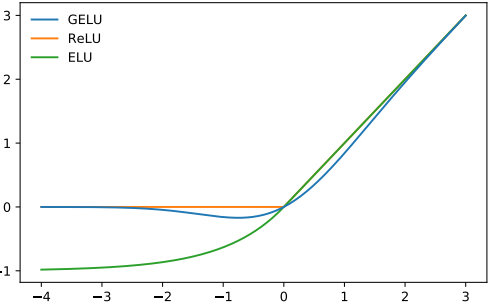

In [15]:
from IPython.display import Image, display

display(Image(filename="fig_1_from_gelu_paper.png"))

It is approximated by the following function:

In [16]:
def gelu(x):
    return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * x**3)))

Like ReLU, GELU operates element-wise on the input:

In [17]:
gelu(np.array([[1, 2], [-2, 0.5]]))

array([[ 0.84119199,  1.95459769],
       [-0.04540231,  0.34571401]])

### Softmax

Good ole [softmax](https://en.wikipedia.org/wiki/Softmax_function):

$$\text{softmax}(x_i) = \frac{e^{x_i}}{\sum_j e^{x_j}}$$

In [18]:
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

We use the [max(x) trick for numerical stability](https://jaykmody.com/blog/stable-softmax/). Softmax is used to a convert set of real numbers (between $-\infty$ and $\infty$) to probabilities (between $0$ and $1$, with the numbers all summing to $1$). We apply `softmax` over the last axis of the input.

In [19]:
x = softmax(np.array([[2, 100], [-5, 0]]))
x

array([[2.74878501e-43, 1.00000000e+00],
       [6.69285092e-03, 9.93307149e-01]])

In [20]:
x.sum(axis=-1)

array([1., 1.])

### Layer Normalization

[Layer normalization](https://arxiv.org/pdf/1607.06450.pdf) standardizes values to have a mean of `0` and a variance of `1`:

$$\text{LayerNorm}(x) = \gamma\cdot\frac{x - \mu}{\sigma} + \beta$$

where $\mu$ is the mean of $x$, $\sigma^2$ is the variance of $x$, and $\gamma$ and $\beta$ are learnable parameters.

In [21]:
def layer_norm(x, g, b, eps: float = 1e-5):
    mean = np.mean(x, axis=-1, keepdims=True)
    variance = np.var(x, axis=-1, keepdims=True)
    x = (x - mean) / np.sqrt(
        variance + eps
    )  # normalize x to have mean=0 and var=1 over last axis
    return g * x + b  # scale and offset with gamma/beta params

Layer normalization ensures that the inputs for each layer are always within a consistent range, which is supposed to speed up and stabilize the training process. Like [**batchnorm**](https://arxiv.org/pdf/1502.03167.pdf), the normalized output is then scaled and offset with two learnable vectors $\gamma$ and $\beta$. The small epsilon term in the denominator (`eps`) is used to avoid a division by zero error. Layer norm is used instead of batch norm in the transformer for [various reasons](https://stats.stackexchange.com/questions/474440/why-do-transformers-use-layer-norm-instead-of-batch-norm). The differences between various normalization techniques is outlined in [this excellent blog post](https://tungmphung.com/deep-learning-normalization-methods/). We apply layer normalization over the last axis of the input:

In [22]:
x = np.array([[2, 2, 3], [-5, 0, 1]])
x = layer_norm(x, g=np.ones(x.shape[-1]), b=np.zeros(x.shape[-1]))
print(x)
print("var:", x.var(axis=-1))  # yields floating point shenanigans
print("mean:", x.mean(axis=-1))  # same here

[[-0.70709087 -0.70709087  1.41418174]
 [-1.39700038  0.50800014  0.88900024]]
var: [0.999955   0.99999855]
mean: [-2.96059473e-16 -3.70074342e-17]


### Linear

Your standard matrix multiplication + bias:

In [23]:
def linear(x, w, b):  # [m, in], [in, out], [out] -> [m, out]
    return x @ w + b

Linear layers are often referred to as projections (since they are projecting from one vector space to another vector space):

In [24]:
x = np.random.normal(size=(64, 784))  # input dim = 784, batch/sequence dim = 64
w = np.random.normal(size=(784, 10))  # output dim = 10
b = np.random.normal(size=(10,))
print(x.shape)  # shape before linear projection
print(linear(x, w, b).shape)  # shape after linear projection

(64, 784)
(64, 10)


## **GPT** Architecture

The **GPT** architecture follows that of the transformer:

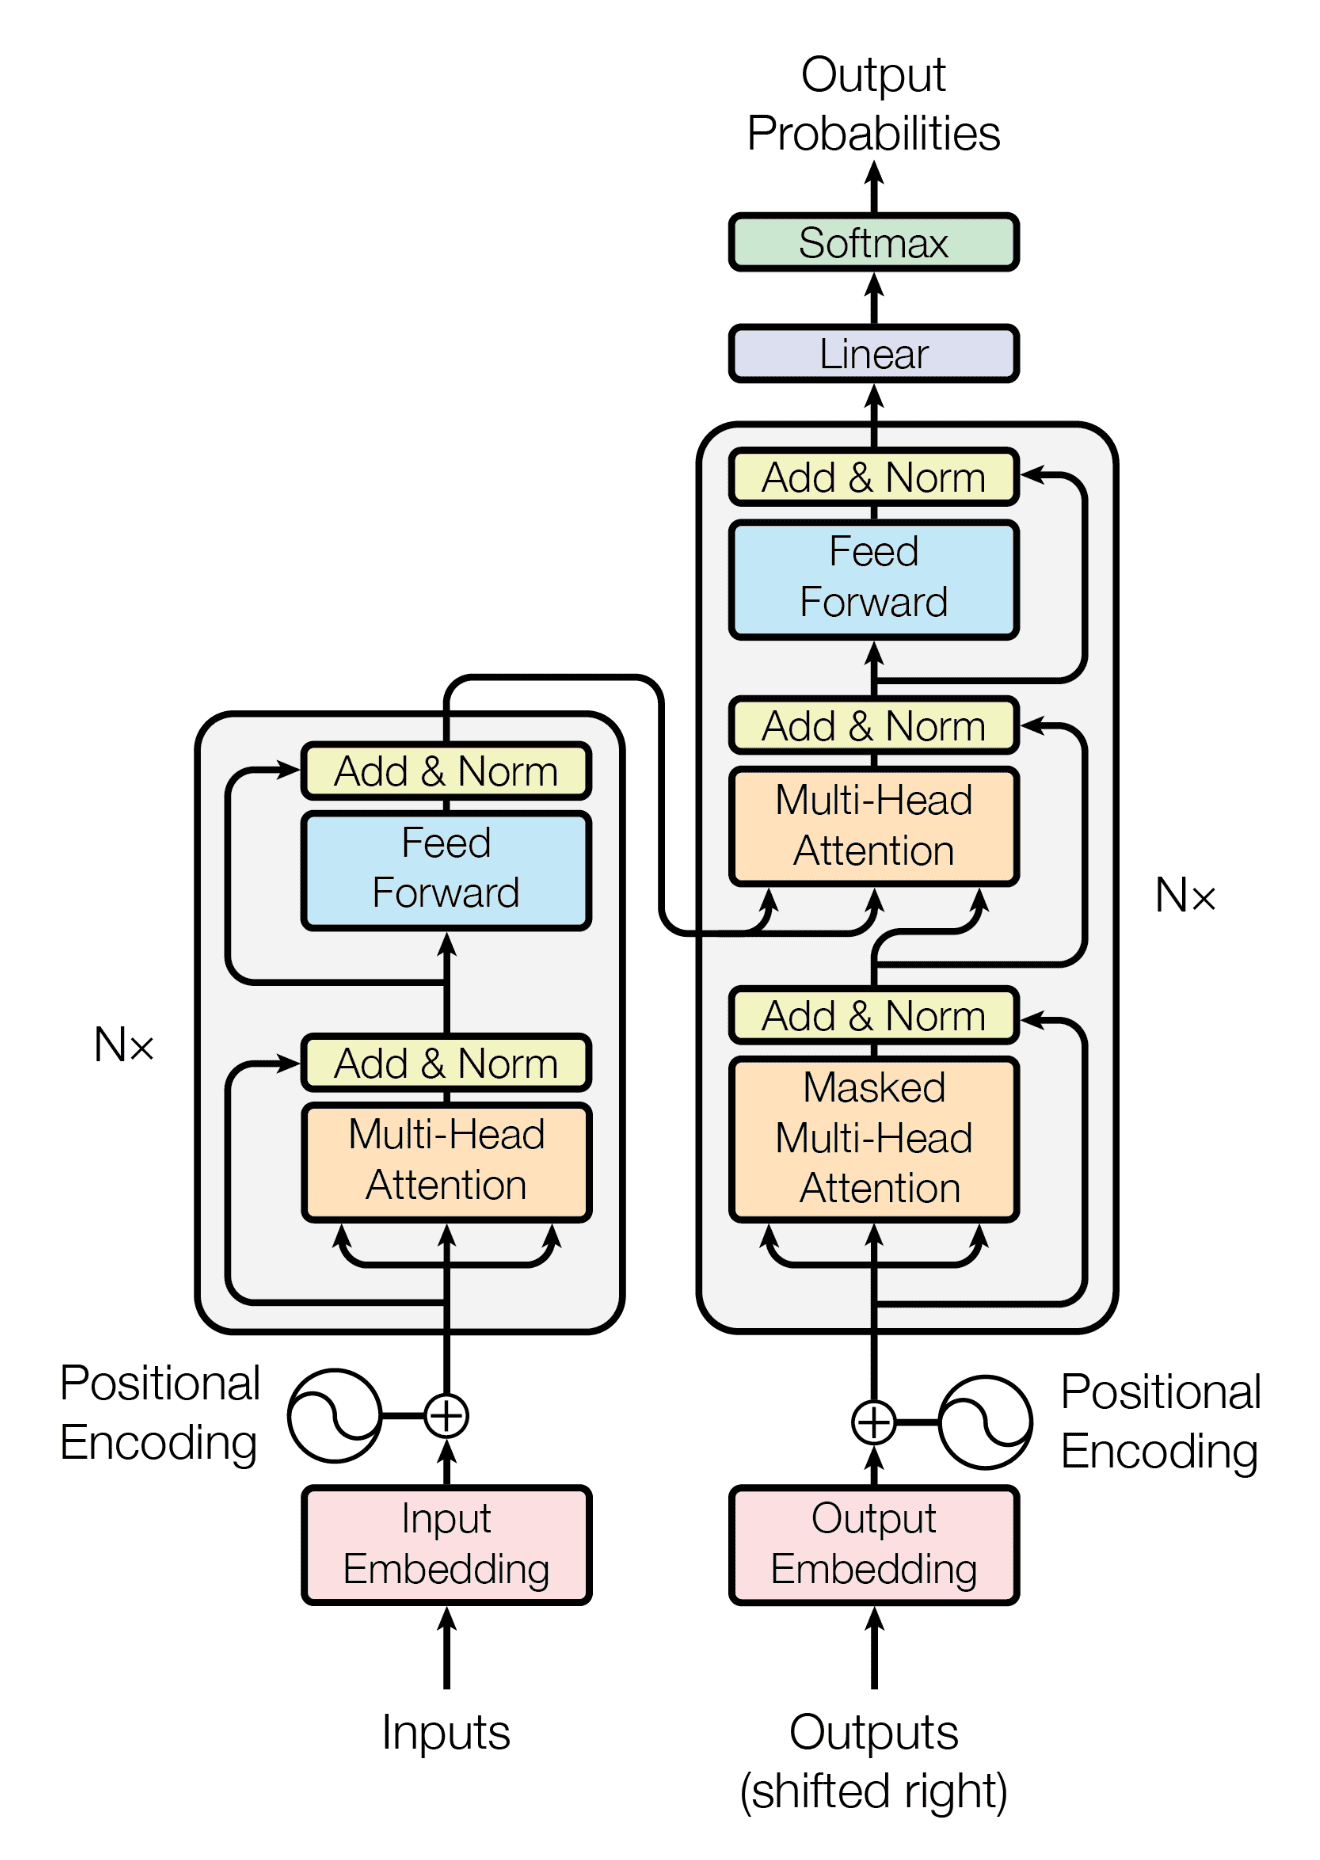

In [25]:
from IPython.display import Image, display

display(Image(filename="fig_1_from_attention_is_all_you_need_paper.png"))

But uses only the decoder stack (the right part of the diagram):

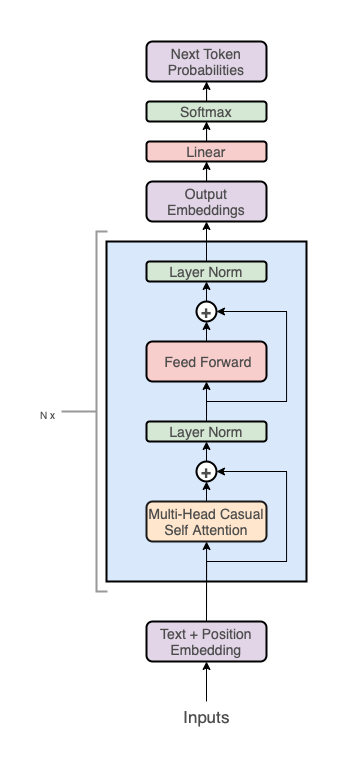

In [26]:
from IPython.display import Image, display

display(Image(filename="transformer_decoder_stack.png"))

Note, the middle "cross-attention" layer is also removed since we got rid of the encoder. At a high level, the **GPT** architecture has three sections:
- Text + positional embeddings
- A transformer decoder stack
- A projection to vocab step

In code, it looks like this:


In [27]:
def gpt2(inputs, wte, wpe, blocks, ln_f, n_head):  # [n_seq] -> [n_seq, n_vocab]
    # token + positional embeddings
    x = wte[inputs] + wpe[range(len(inputs))]  # [n_seq] -> [n_seq, n_embd]

    # forward pass through n_layer transformer blocks
    for block in blocks:
        x = transformer_block(
            x, **block, n_head=n_head
        )  # [n_seq, n_embd] -> [n_seq, n_embd]

    # projection to vocab
    x = layer_norm(x, **ln_f)  # [n_seq, n_embd] -> [n_seq, n_embd]
    return x @ wte.T  # [n_seq, n_embd] -> [n_seq, n_vocab]

Let's break down each of these three sections into more detail.

### Embeddings

#### Token Embeddings

Token IDs by themselves are not very good representations for a **nn**. For one, the relative magnitudes of the token IDs falsely communicate information (for example, if `Apple = 5` and `Table = 10` in our vocab, then we are implying that `2 * Apple = Table`). Secondly, a single number is not a lot of dimensionality for a **nn** to work with. To address these limitations, we'll take advantage of [word vectors](https://jaykmody.com/blog/attention-intuition/#word-vectors-and-similarity), specifically via a learned embedding matrix:

```python
wte[inputs]  # [n_seq] -> [n_seq, n_embd]
```

Recall, `wte` is a `[n_vocab, n_embd]` matrix. It acts as a lookup table, where the $ith$ row in the matrix corresponds to the learned vector for the $ith$ token in our vocabulary. `wte[inputs]` uses [integer array indexing](https://numpy.org/doc/stable/user/basics.indexing.html#integer-array-indexing) to retrieve the vectors corresponding to each token in our input. Like any other parameter in our network, `wte` is learned. That is, it is randomly initialized at the start of training and then updated via gradient descent.

#### Positional Embeddings

One quirk of the transformer architecture is that it doesn't take into account position. That is, if we randomly shuffled our input and then accordingly unshuffled the output, the output would be the same as if we never shuffled the input in the first place (the ordering of inputs doesn't have any effect on the output). Of course, the ordering of words is a crucial part of language (duh), so we need some way to encode positional information into our inputs. For this, we can just use another learned embedding matrix:

```python
wpe[range(len(inputs))]  # [n_seq] -> [n_seq, n_embd]
```

Recall, `wpe` is a `[n_ctx, n_embd]` matrix. The $ith$ row of the matrix contains a vector that encodes information about the $ith$ position in the input. Similar to $wte$, this matrix is learned during gradient descent. Notice, this restricts our model to a maximum sequence length of `n_ctx`. That is, `len(inputs) <= n_ctx` must hold.

*Note*: The original transformer paper used a [calculated positional embedding](https://nlp.seas.harvard.edu/2018/04/03/attention.html#positional-encoding) which they found performed just as well as learned positional embeddings, but has the distinct advantage that you can input any arbitrarily long sequence (you are not restricted by a maximum sequence length). However, in practice, your model is only going to be as the good sequence lengths that it was trained on. You can't just train a **GPT** on sequences that are $1024$ long and then expect it to perform well at 16k tokens long. Recently however, there has been some success with relative positional embeddings, such as [Alibi](https://arxiv.org/pdf/2108.12409.pdf) and [RoPE](https://arxiv.org/pdf/2104.09864v4.pdf). 

#### Combined

We can add our token and positional embeddings to get a combined embedding that encodes both token and positional information:

```python
# token + positional embeddings
x = wte[inputs] + wpe[range(len(inputs))]  # [n_seq] -> [n_seq, n_embd]

# x[i] represents the word embedding for the ith word + the positional
# embedding for the ith position
```

### Decoder Stack

This is where all the magic happens and the "deep" in deep learning comes in. We pass our embedding through a stack of `n_layer` transformer decoder blocks:

```python
# forward pass through n_layer transformer blocks
for block in blocks:
    x = transformer_block(
        x, **block, n_head=n_head
    )  # [n_seq, n_embd] -> [n_seq, n_embd]
```

Stacking more layers is what allows us to control how deep our network is. **GPT**-3 for example, has a whopping $96$ layers. On the other hand, choosing a larger `n_embd` value allows us to control how *wide* our network is (for example, **GPT**-3 uses an embedding size of $12288$).

### Projection to Vocab

In our final step, we project the output of the final transformer block to a probability distribution over our vocab:

```python
# projection to vocab
x = layer_norm(x, **ln_f)  # [n_seq, n_embd] -> [n_seq, n_embd]
return x @ wte.T  # [n_seq, n_embd] -> [n_seq, n_vocab]
```

Couple things to note here:

1. We first pass `x` through a final layer normalization layer before doing the projection to vocab. This is specific to the **GPT**-2 architecture (this is not present in the original **GPT** and Transformer papers).
2. We are reusing the embedding matrix `wte` for the projection.  Other **GPT** implementations may choose to use a separate learned weight matrix for the projection, however sharing the embedding matrix has a couple of advantages:
    - You save some parameters (although at **GPT**-3 scale, this is negligible).
    - Since the matrix is both responsible for mapping both *to* words and *from* words, in theory, it *may* learn a richer representation compared to having two separate matrixes.
3. We don't apply `softmax` at the end, so our outputs will be logits instead of probabilities between $0$ and $1$. This is done for several reasons:
    - `softmax` is [monotonic](https://en.wikipedia.org/wiki/Monotonic_function), so for greedy sampling `np.argmax(logits)` is equivalent to `np.argmax(softmax(logits))` making `softmax` redundant
    - `softmax` is irreversible, meaning we can always go from logits to probabilities by applying `softmax`, but we can't go back to logits from probabilities, so for maximum flexibility, we output the logits
    - Numerically stability (for example, to compute cross entropy **loss**, taking `log(softmax(logits))` is numerically unstable compared to `log_softmax(logits)`

The projection to vocab step is also sometimes called the language modeling head. What does "head" mean? Once your **GPT** is pre-trained, you can swap out the language modeling head with some other kind of projection, like a classification head for fine-tuning the model on some classification task. So your model can have multiple heads, kind of like a [hydra](https://en.wikipedia.org/wiki/Lernaean_Hydra). So that's the **GPT** architecture at a high level, let's actually dig a bit deeper into what the decoder blocks are doing.

### Decoder Block

The transformer decoder block consists of two sublayers:
1. Multi-head causal self attention
2. Position-wise feed forward **nn**

In [28]:
def transformer_block(
    x, mlp, attn, ln_1, ln_2, n_head
):  # [n_seq, n_embd] -> [n_seq, n_embd]
    # multi-head causal self attention
    x = x + mha(
        layer_norm(x, **ln_1), **attn, n_head=n_head
    )  # [n_seq, n_embd] -> [n_seq, n_embd]
    # position-wise feed forward network
    x = x + ffn(layer_norm(x, **ln_2), **mlp)  # [n_seq, n_embd] -> [n_seq, n_embd]
    return x

Each sublayer utilizes layer normalization on their inputs as well as a residual connection (i.e. add the input of the sublayer to the output of the sublayer). Some things to note:

1. Multi-head causal self attention is what facilitates the communication between the inputs. Nowhere else in the network does the model allow inputs to "see" each other. The embeddings, position-wise feed forward network, layer norms, and projection to vocab all operate on our inputs position-wise. Modeling relationships between inputs is tasked solely to attention.
2. The Position-wise feed forward **nn** is just a regular 2 layer fully connected **nn**. This just adds a bunch of learnable parameters for our model to work with to facilitate learning.
3. In the original transformer paper, layer norm is placed on the output `layer_norm(x + sublayer(x))` while we place layer norm on the input `x + sublayer(layer_norm(x))` to match **GPT**-2. This is referred to as pre-norm and has been shown to be [important in improving the performance of the transformer](https://arxiv.org/pdf/2002.04745.pdf).
4. Residual connections (popularized by ResNet) serve a couple of different purposes:
    - Makes it easier to optimize **nn**s that are deep (i.e. networks that have lots of layers). The idea here is that we are providing "shortcuts" for the gradients to flow back through the network, making it easier to optimize the earlier layers in the network.
    - Without residual connections, deeper models see a degradation in performance when adding more layers (possibly because it's hard for the gradients to flow all the way back through a deep network without losing information). Residual connections seem to give a bit of an accuracy boost for deeper networks.
    - Can help with the [vanishing/exploding gradients problem](https://programmathically.com/understanding-the-exploding-and-vanishing-gradients-problem/).

Let's dig a little deeper into the 2 sublayers.

### Position-wise Feed Forward Network

This is just a simple multi-layer perceptron with 2 layers:

In [29]:
def ffn(x, c_fc, c_proj):  # [n_seq, n_embd] -> [n_seq, n_embd]
    # project up
    a = gelu(linear(x, **c_fc))  # [n_seq, n_embd] -> [n_seq, 4*n_embd]

    # project back down
    x = linear(a, **c_proj)  # [n_seq, 4*n_embd] -> [n_seq, n_embd]

    return x

Nothing super fancy here, we just project from `n_embd` up to a higher dimension `4*n_embd` and then back down to `n_embd[4]`.

*Note*: Different **GPT** models may choose a different hidden width that is not `4*n_embd`, however this is the common practice for **GPT** models. Also, we give the multi-head attention layer a lot of *attention* (pun intended) for driving the success of the transformer, but at the scale of **GPT**-3, $80\%$ of the model parameters are contained in the feed forward layer. Just something to think about.

Recall, from our params dictionary, that our mlp params look like this:

```python
"mlp": {
    "c_fc": {"b": [4*n_embd], "w": [n_embd, 4*n_embd]},
    "c_proj": {"b": [n_embd], "w": [4*n_embd, n_embd]},
},
```

### Multi-Head Causal Self Attention

This layer is probably the most difficult part of the transformer to understand. So let's work our way up to "Multi-Head Causal Self Attention" by breaking each word down into its own section:

1. Attention
2. Self
3. Causal
4. Multi-Head


#### Attention

ChatGPT and other large language models use a special type of **nn** called the transformer. The transformer defining feature is the attention mechanism. Attention is defined by the equation:

$$\text{attention}(Q, K, V) = \text{softmax}(\frac{QK^T}{\sqrt{d_k}})V$$

Attention can come in different forms, but this version of attention (known as scaled dot product attention) was first proposed in the [original transformer paper](https://arxiv.org/pdf/1706.03762.pdf). In this post, we'll build an intuition for the above equation by deriving it from the ground up.

##### Key-Value Lookups

A key-value (kv) lookup involves three components:
1. A list of $n_k$ **keys**
2. A list of $n_k$ **values** (that map 1-to-1 with the keys, forming key-value pairs)
3. A **query**, for which we want to *match* with the keys and get some value based on the match

You're probably familiar with this concept as a dictionary or hash map:

In [30]:
d = {
    "apple": 10,
    "banana": 5,
    "chair": 2,
}
print(d.keys())
print(d.values())
query = "apple"
d[query]

dict_keys(['apple', 'banana', 'chair'])
dict_values([10, 5, 2])


10

Dictionaries let us perform lookups based on an exact string match. What if instead we wanted to do a lookup based on the meaning of a word?

##### Key-Value Lookups based on Meaning

Say we wanted to look up the word "fruit" in our previous example, how do we choose which key is the best match? It's obviously not "chair", but both "apple" and "banana" seem like a good match. It's hard to choose one or the other, fruit feels more like a combination of apple and banana rather than a strict match for either. So, let's not choose. Instead, we'll do exactly that, take a combination of apple and banana. For example, say we assign a $60\%$ meaning based match for apple, a $40\%$ match for banana, and $0\%$ match for chair. We compute our final output value as the weighted sum of the values with the percentages:

In [31]:
query = "fruit"
d = {"apple": 10, "banana": 5, "chair": 2}
0.6 * d["apple"] + 0.4 * d["banana"] + 0.0 * d["chair"]

8.0

In a sense, we are determining how much attention our query should be paying to each key-value pair based on `meaning`. The amount of "attention" is represented as a decimal percentage, called an attention score. Mathematically, we can define our output as a simple weighted sum:

$$\sum_{i} \alpha_i v_i$$

where $\alpha_i$ is our attention score for the $ith$ kv pair and $v_i$ is the $ith$ value. Remember, the attention scores are decimal percentages, that is they must be between $0$ and $1$ inclusive ($0 \leq \alpha_i \leq 1$) and their sum must be $1$ ($\sum_{i} \alpha_i = 1$). Okay, but where did we get these attention scores from? In our example, we kind of chose them based on what we felt. While we did a pretty good job, this approach doesn't seem sustainable. Instead, let's take a look at how word vectors can help solve our problem of determining attention scores.

##### Word Vectors and Similarity

Imagine we represent a word with a vector of numbers. Ideally, the values in the vector should in some way capture the *meaning* of the word it represents. For example, imagine we have the following word vectors (visualized in 2D space):

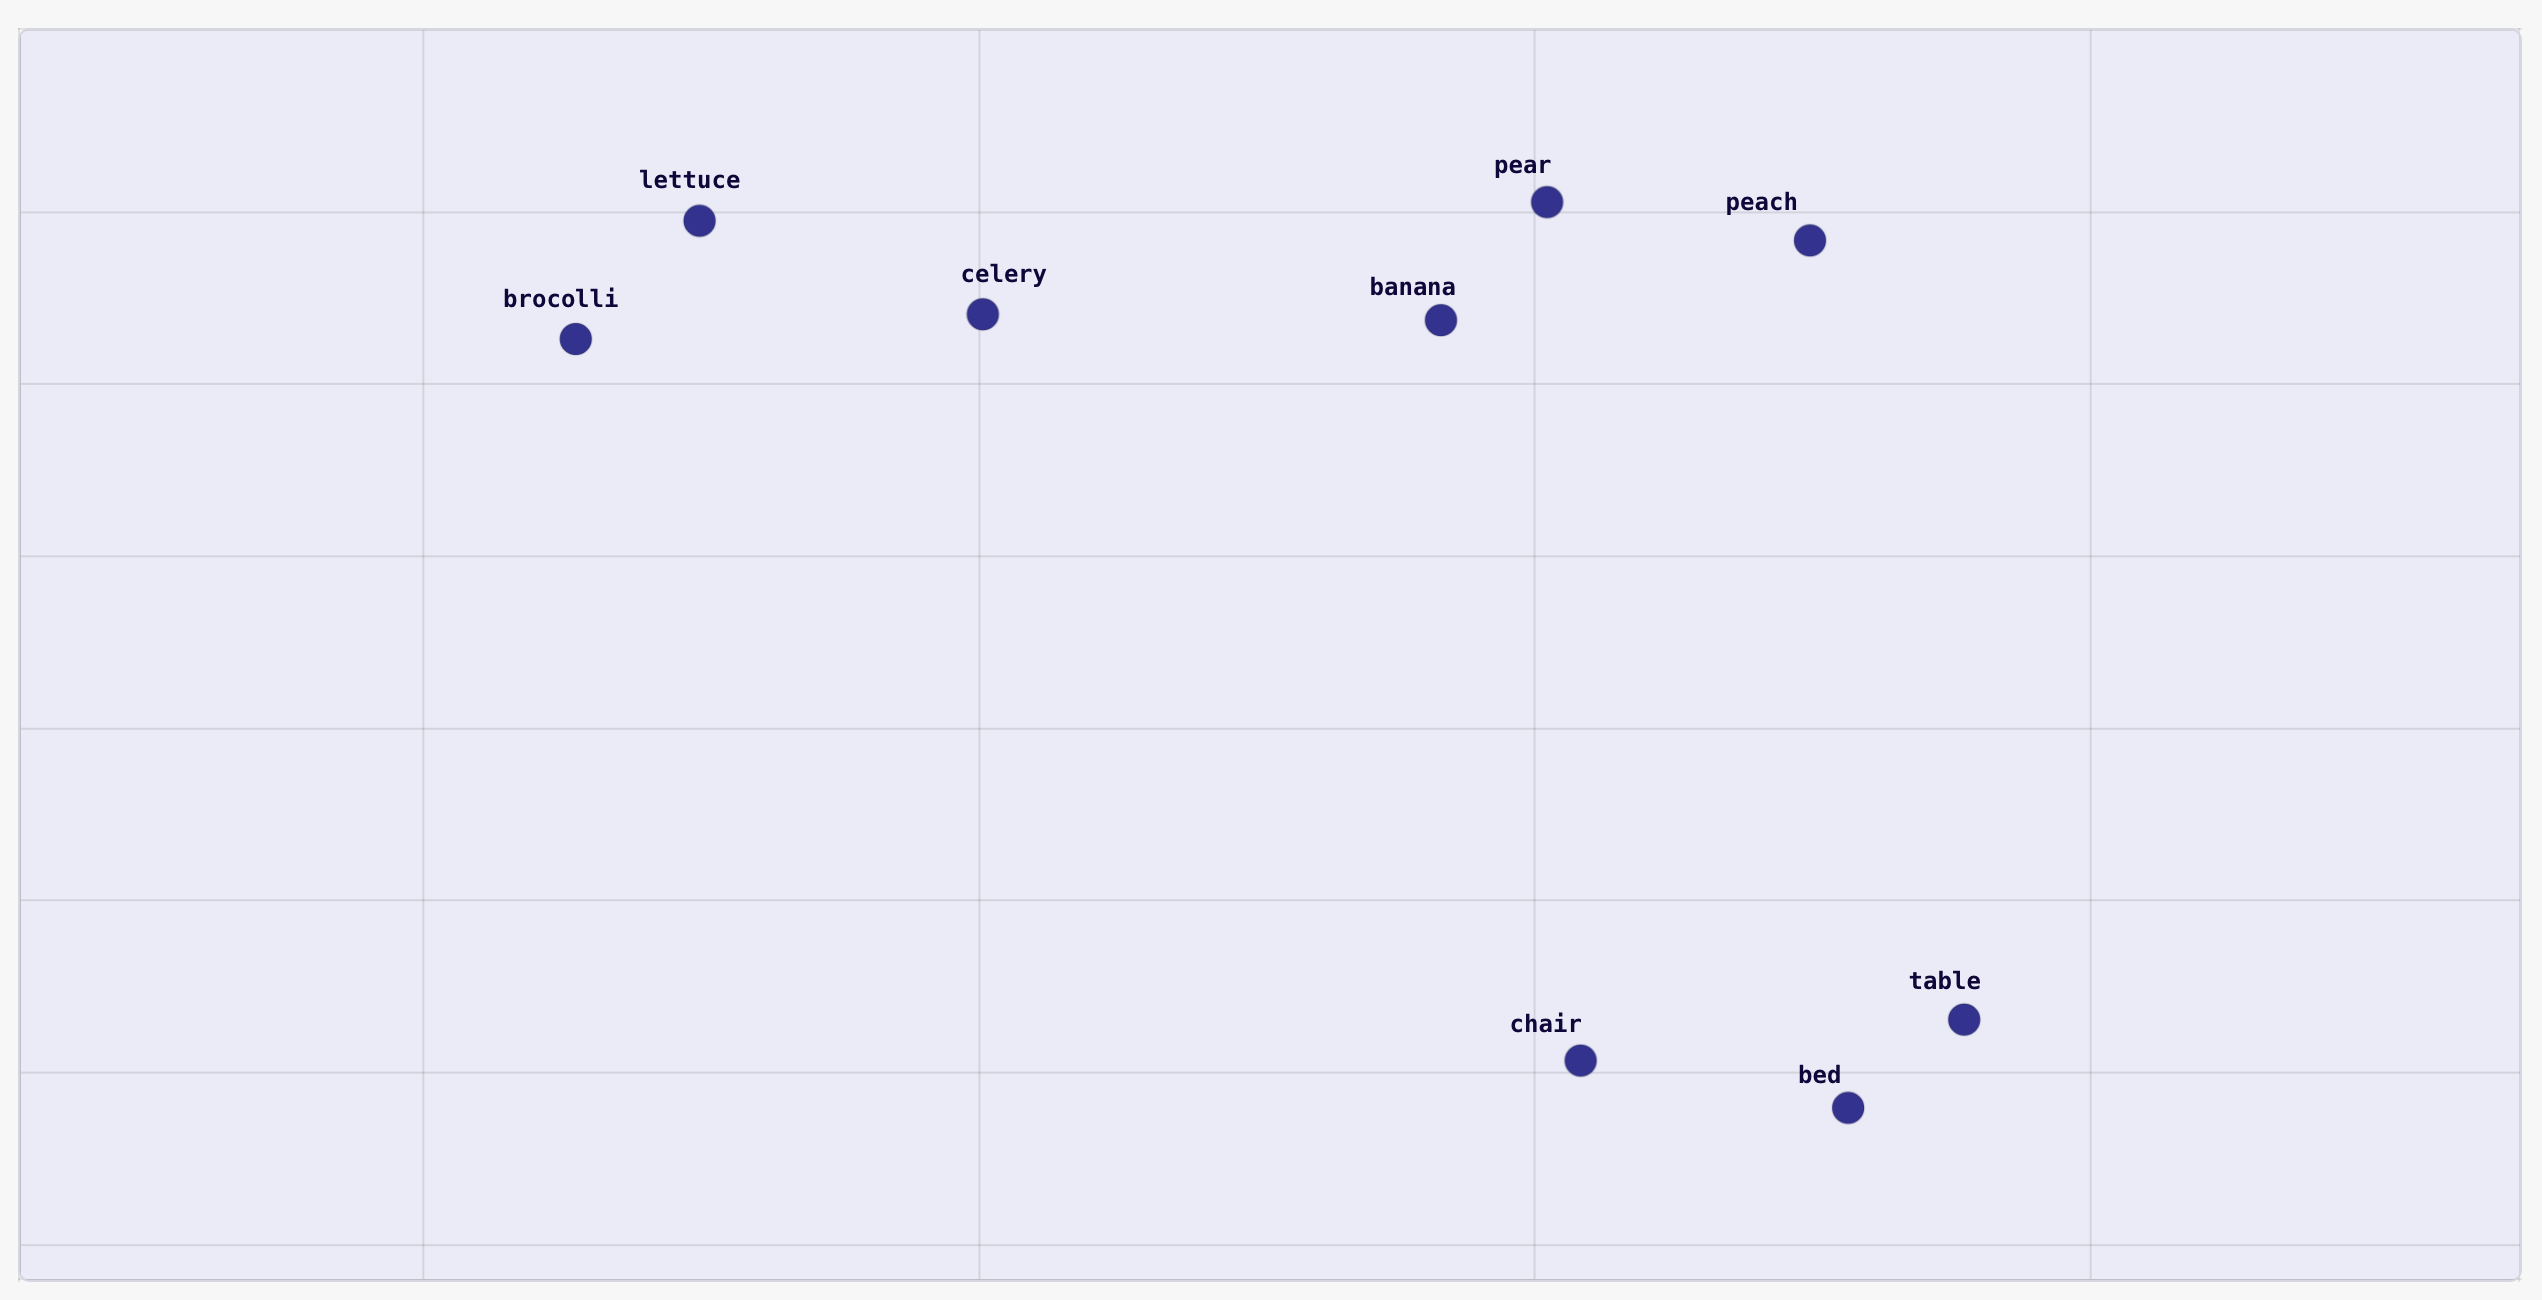

In [32]:
from IPython.display import Image, display

display(Image(filename="2d_word_vectors_example.png"))

You can see that words that are *similar* are clustered together. Fruits are clustered at the top right, vegetables are clustered at the top left, and furniture is clustered at the bottom. In fact, you can even see that the vegetable and fruit clusters are closer to each other than they are to the furniture cluster, since they are more closely related things. You can even imagine doing arithmetic on word vectors. For example, given the words "king", "queen", "man", and "woman" and their respective vector representations $v_{king}$, $v_{queen}$, $v_{man}$, and $v_{woman}$, we can imagine that: 

$$v_{queen} - v_{woman} + v_{man} \sim v_{king}$$

That is, the vector for "queen" minus "woman" plus "man" should result in a vector that is *similar* to the vector for "king". But what does it exactly mean for two vectors to be *similar*? In the fruits/vegetables example, we were using distance as a measure of similarity (in particular, [euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance)). There are also [other ways to measure similarity between two vectors](https://towardsdatascience.com/9-distance-measures-in-data-science-918109d069fa), each with its own advantages and disadvantages. Possibly the simplest measure of similarity between two vectors is their dot product:

$$\textbf{v} \cdot \textbf{w} = \sum_{i} v_i w_i$$

[3blue1brown has a great video on the intuition behind dot product](https://www.youtube.com/watch?v=LyGKycYT2v0), but for our purposes all we need to know is:

- If two vectors are pointing in the same direction, the dot product will be $> 0$ (i.e. *similar*)
- If they are pointing in opposing directions, the dot product will be $< 0$ (i.e. *dissimilar*)
- If they are exactly perpendicular, the dot product will be $0$ (i.e. *neutral*)

Using this information, we can define a simple heuristic to determine the similarity between two word vectors: The greater the dot product, the more similar two words are in *meaning*.

*Note*: You'll note that the magnitude of the vectors have an influence on the output of dot product. For example, given 3 vectors, $a = [1, 1, 1]$, $b = [1000, 0, 0]$, $c = [2, 2, 2]$, our dot product heuristic would tell us that because $a \cdot b > a \cdot c$, that $a$ is more similar to $c$ than $a$ is to $b$. This doesn't seem right, since $a$ and $b$ are pointing in the exact same direction, while $a$ and $c$ are not. [Cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) accounts for this normalizing the vectors to unit vectors before taking the dot product, essentially ignoring the magnitudes and only caring about the direction. So why don't we take the cosine similarity? In a deep learning setting, the magnitude of a vector might actually contain information we care about (and we shouldn't get rid of it). Also, if we regularize our networks properly, outlier examples like the above should not occur.

Okay cool, but where do these word vectors actually come from? They usually come from some kind of learned embedding or latent representation. That is, initially the word vectors are just random numbers, but as the **nn** is trained, their values are adjusted to become better and better representations for words.

##### Attention Scores using the Dot Product

Let's return to our example of fruits, but this time around using word vectors to represent our words. That is $\textbf{q} = \textbf{v}_{fruit}$ and $\textbf{k} = [\textbf{v}_{apple} \textbf{v}_{banana} \textbf{v}_{chair}]$, such that $\textbf{v} \in \mathbb{R}^{d_k}$ (that is each vector has the same dimensionality of $d_k$, which is a value we choose when training a **nn**). Using our new dot product similarity measure, we can compute the similarity between the query and the $ith$ key as:

$$\textbf{x}_i = \textbf{q} \cdot \textbf{k}_i$$

where $\textbf{a}_i$ is the attention score for the $ith$ key-value pair.  Generalizing this further, we can compute the dot product for all $n_k$ keys with:

$$\textbf{x} = \textbf{q} \cdot \textbf{K}^T$$

where $\textbf{x}$ is our vector of dot products $\textbf{x} = [x_1, x_2, ..., x_{n_k - 1}, x_{n_k}]$ and $K$ is a row-wise matrix of our key vectors (i.e. our key vectors stacked on-top of each-other to form a $n_k \times d_k$ matrix such that $k_i$ is the $ith$ row of $K$). If you're having trouble understanding this, here's an explanation:

Basically, instead of computing each dot product separately:

$$x_1 = \textbf{q} \cdot \textbf{k}_1 = [2, 1, 3] \cdot [-1, 2, -1] = -3$$
$$x_2 = \textbf{q} \cdot \textbf{k}_2 = [2, 1, 3] \cdot [1.5, 0, -1] = 0$$
$$x_3 = \textbf{q} \cdot \textbf{k}_3 = [2, 1, 3] \cdot [4, -2, -1] = 3$$

You compute it all at once:

$$\textbf{x} = \textbf{q} \cdot \textbf{K}^T = [2, 1, 3] \cdot \begin{bmatrix} -1 & 2 & -1 \\ 1.5 & 0 & -1 \\ 4 & -2 & -1 \end{bmatrix}^T = [2, 1, 3] \cdot \begin{bmatrix} -1 & 1.5 & 4 \\ 2 & 0 & -2 \\ -1 & -1 & -1 \end{bmatrix} = [-3, 0, 3] = [x_1, x_2, x_3]$$

Now, recall that our attention scores need to be decimal percentages (between $0$ and $1$ and sum to $1$). Our dot product values however can be any real number (i.e. between $-\infty$ and $\infty$). To transform our dot product values to decimal percentages, we'll use the softmax function:

$$\text{softmax}(x) = \frac{e^{x_i}}{\sum_{j} e^{x_j}}$$

e.g.

In [33]:
softmax(np.array([4.0, -1.0, 2.1]))

array([0.86482256, 0.00582713, 0.12935032])

Notice:
- ✅ Each number is between $0$ and $1$
- ✅ The numbers sum to $1$
- ✅ The larger valued inputs get more "weight"
- ✅ The sorted order is preserved (i.e. the $4.0$ is still the largest after softmax, and $-1.0$ is still the lowest), this is because softmax is a [monotonic function](https://en.wikipedia.org/wiki/Monotonic_function)

This satisfies all the desired properties of an attention scores. Thus, we can compute the attention score for the $ith$ key-value pair with:

$$a_i = \text{softmax}(x)_i = \text{softmax}(\textbf{q} \textbf{K}^T)_i$$

Plugging this into our weighted sum we get:

$$\sum_{i} a_i v_i = \sum_{i} \text{softmax}(\textbf{x})_i v_i = \sum_{i} \text{softmax}(\textbf{q} \textbf{K}^T)_i v_i = \text{softmax}(\textbf{q} \textbf{K}^T) \textbf{v}$$

Note: In the last step, we pack our values into a vector $\textbf{v} = [v_1, v_2, ..., v_{n_k - 1}, v_{n_k}]$, which allows us to get rid of the summation notation in favor of a dot product. And that's it, we have a full working definition for attention:

$$\text{attention}(\textbf{q}, K, \textbf{v}) = \text{softmax}(\textbf{qK}^T)\textbf{v}$$

In code:

In [34]:
def get_word_vector(word, d_k=8):
    """Hypothetical mapping that returns a word vector of size
    d_k for the given word. For demonstrative purposes, we initialize
    this vector randomly, but in practice this would come from a learned
    embedding or some kind of latent representation."""
    return np.random.normal(size=(d_k,))


def attention(q, K, v):
    # assumes q is a vector of shape (d_k)
    # assumes K is a matrix of shape (n_k, d_k)
    # assumes v is a vector of shape (n_k)
    return softmax(q @ K.T) @ v


def kv_lookup(query, keys, values):
    return attention(
        q=get_word_vector(query),
        K=np.array([get_word_vector(key) for key in keys]),
        v=values,
    )


# returns some float number
print(kv_lookup("fruit", ["apple", "banana", "chair"], [10, 5, 2]))

6.589311199486881


##### Scaled Dot Product Attention

In principle, the attention equation we derived in the last section is complete. However, we'll need to make a couple of changes to match the version in [Attention is All You Need](https://arxiv.org/pdf/1706.03762.pdf).

**Values as Vectors**

Currently, our values in the key-value pairs are just numbers. However, we could also instead replace them with vectors of some size $d_v$. For example, with $d_v = 4$, you might have:

```python
d = {
    "apple": [0.9, 0.2, -0.5, 1.0]
    "banana": [1.2, 2.0, 0.1, 0.2]
    "chair": [-1.2, -2.0, 1.0, -0.2]
}
```

When we compute our output via a weighted sum, we'd be doing a weighted sum over vectors instead of numbers (i.e. scalar-vector multiplication instead of scalar-scalar multiplication). This is desirable because vectors let us hold/convey more information than just a single number. To adjust for this change in our equation, instead of multiplying our attention scores by a vector $v$, we multiply it by the row-wise matrix of our value vectors $V$ (similar to how we stacked our keys to form $K$):

$$\text{attention}(\textbf{q}, K, V) = \text{softmax}(\textbf{qK}^T)V$$

Of course, our output is no longer a scalar, instead it would be a vector of dimensionality $d_v$.

**Scaling**

The dot product between our query and keys can get really large in magnitude if $d_k$ is large. This makes the output of softmax more *extreme*. For example, `softmax([3, 2, 1]) = [0.665, 0.244, 0.090]`, but with larger values `softmax([30, 20, 10]) = [9.99954600e-01, 4.53978686e-05, 2.06106005e-09]`. When training a **nn**, this would mean the gradients would become really small which is undesirable. As a solution, we scale our pre-softmax scores by $\frac{1}{\sqrt{d_k}}$:

$$\text{attention}(\textbf{q}, K, V) = \text{softmax}(\frac{\textbf{qK}^T}{\sqrt{d_k}})V$$

**Multiple Queries**

In practice, we often want to perform multiple lookups for $n_q$ different queries rather than just a single query. Of course, we could always do this one at a time, plugging each query individually into the above equation. However, if we stack of query vectors row-wise as a matrix $Q$ (in the same way we did for $K$ and $V$), we can compute our output as an $n_q \times d_v$ matrix where row $i$ is the output vector for the attention on the $ith$ query:

$$\text{attention}(Q, K, V) = \text{softmax}(\frac{QK^T}{\sqrt{d_k}})V$$

that is, $$\text{attention}(Q, K, V)_i = \text{attention}(q_i, K, V)$$

This makes computation faster than if we ran attention for each query sequentially (say, in a for loop) since we can parallelize calculations (particularly when using a GPU). Note, our input to softmax becomes a matrix instead of a vector. When we write softmax here, we mean that we are taking the softmax along each row of the matrix independently, as if we were doing things sequentially.

**Result**

With that, we have our final equation for scaled dot product attention as it's written in the [original transformer paper](https://arxiv.org/pdf/1706.03762.pdf):

$$\text{attention}(Q, K, V) = \text{softmax}(\frac{QK^T}{\sqrt{d_k}})V$$

In code:


    

In [35]:
def attention(q, k, v):  # [n_q, d_k], [n_k, d_k], [n_k, d_v] -> [n_q, d_v]
    # assumes q is a matrix of shape [n_q, d_k]
    # assumes k is a matrix of shape [n_k, d_k]
    # assumes v is a matrix of shape [n_k, d_v]
    # output is a matrix of shape [n_q, d_v]
    d_k = k.shape[-1]
    return softmax(q @ k.T / np.sqrt(d_k)) @ v

#### Self

When `q`, `k`, and `v` all come from the same source, we are performing [self-attention](https://lilianweng.github.io/posts/2018-06-24-attention/#self-attention) (i.e. letting our input sequence attend to itself):

In [36]:
def self_attention(x):  # [n_seq, n_embd] -> [n_seq, n_embd]
    return attention(q=x, k=x, v=x)

For example, if our input is `Jay went to the store, he bought 10 apples.`, we would be letting the word `he` attend to all the other words, including `Jay`, meaning the model can learn to recognize that `he` is referring to `Jay`. We can enhance self attention by introducing projections for `q`, `k`, `v` and the attention output:

In [37]:
def self_attention(x, w_k, w_q, w_v, w_proj):  # [n_seq, n_embd] -> [n_seq, n_embd]
    # qkv projections
    q = x @ w_q  # [n_seq, n_embd] @ [n_embd, n_embd] -> [n_seq, n_embd]
    k = x @ w_k  # [n_seq, n_embd] @ [n_embd, n_embd] -> [n_seq, n_embd]
    v = x @ w_v  # [n_seq, n_embd] @ [n_embd, n_embd] -> [n_seq, n_embd]

    # perform self attention
    x = attention(q, k, v)  # [n_seq, n_embd] -> [n_seq, n_embd]

    # out projection
    x = x @ w_proj  # [n_seq, n_embd] @ [n_embd, n_embd] -> [n_seq, n_embd]

    return x

This enables our model to learn a mapping for `q`, `k`, and `v` that best helps attention distinguish relationships between inputs. We can reduce the number of matrix multiplication from $4$ to just $2$ if we combine `w_q`, `w_k` and `w_v` into a single matrix `w_fc`, perform the projection, and then split the result:

In [38]:
def self_attention(x, w_fc, w_proj):  # [n_seq, n_embd] -> [n_seq, n_embd]
    # qkv projections
    x = x @ w_fc  # [n_seq, n_embd] @ [n_embd, 3*n_embd] -> [n_seq, 3*n_embd]

    # split into qkv
    q, k, v = np.split(x, 3, axis=-1)  # [n_seq, 3*n_embd] -> 3 of [n_seq, n_embd]

    # perform self attention
    x = attention(q, k, v)  # [n_seq, n_embd] -> [n_seq, n_embd]

    # out projection
    x = x @ w_proj  # [n_seq, n_embd] @ [n_embd, n_embd] = [n_seq, n_embd]

    return x

This is a bit more efficient as modern accelerators (GPUs) can take better advantage of one large matrix multiplication rather than $3$ separate small ones happening sequentially. Finally, we add bias vectors to match the implementation of **GPT**-2, use our `linear` function, and rename our parameters to match our `params` dictionary:

In [39]:
def self_attention(x, c_attn, c_proj):  # [n_seq, n_embd] -> [n_seq, n_embd]
    # qkv projections
    x = linear(x, **c_attn)  # [n_seq, n_embd] -> [n_seq, 3*n_embd]

    # split into qkv
    q, k, v = np.split(x, 3, axis=-1)  # [n_seq, 3*n_embd] -> 3 of [n_seq, n_embd]

    # perform self attention
    x = attention(q, k, v)  # [n_seq, n_embd] -> [n_seq, n_embd]

    # out projection
    x = linear(x, **c_proj)  # [n_seq, n_embd] @ [n_embd, n_embd] = [n_seq, n_embd]

    return x

Recall, from our `params` dictionary, our `attn` params look like this:

```python
"attn": {
    "c_attn": {"b": [3*n_embd], "w": [n_embd, 3*n_embd]},
    "c_proj": {"b": [n_embd], "w": [n_embd, n_embd]},
},
```

#### Causal

There is a bit of an issue with our current self-attention setup, our inputs can see into the future! For example, if our input is `["not", "all", "heroes", "wear", "capes"]`, during self attention we are allowing `"wear"` to see `"capes"`. This means our output probabilities for `"wear"` will be biased since the model already knows the correct answer is `"capes"`. This is no good since our model will just learn that the correct answer for input $i$ can be taken from input $i+1$. To prevent this, we need to somehow modify our attention matrix to *hide* or **mask** our inputs from being able to see into the future. For example, let's pretend our attention matrix looks like this:

```js
       not    all    heroes wear   capes
   not 0.116  0.159  0.055  0.226  0.443
   all 0.180  0.397  0.142  0.106  0.175
heroes 0.156  0.453  0.028  0.129  0.234
  wear 0.499  0.055  0.133  0.017  0.295
 capes 0.089  0.290  0.240  0.228  0.153
 ```

 Each row corresponds to a query and the columns to a key. In this case, looking at the row for `wear`, you can see that it is attending to `capes` in the last column with a weight of $0.295$. To prevent this, we want to set that entry to $0.000$:

```js
        not    all    heroes wear   capes
   not 0.116  0.159  0.055  0.226  0.443
   all 0.180  0.397  0.142  0.106  0.175
heroes 0.156  0.453  0.028  0.129  0.234
  wear 0.499  0.055  0.133  0.017  0.000
 capes 0.089  0.290  0.240  0.228  0.153
```

 In general, to prevent all the queries in our input from looking into the future, we set all positions $i, j$ where $j > i$ to $0.000$:

```js
        not    all    heroes wear   capes
   not 0.116  0.000  0.000  0.000  0.000
   all 0.180  0.397  0.000  0.000  0.000
heroes 0.156  0.453  0.028  0.000  0.000
  wear 0.499  0.055  0.133  0.017  0.000
 capes 0.089  0.290  0.240  0.228  0.153
```

We call this **masking**. One issue with our above **masking** approach is our rows no longer sum to $1$ (since we are setting them to $0$ after the `softmax` has been applied). To make sure our rows still sum to $1$, we need to modify our attention matrix before the `softmax` is applied. This can be achieved by setting entries that are to be masked to $-\infty$ prior to the `softmax`.

*Note*: If you're not convinced, stare at the softmax equation and convince yourself this is true (maybe even pull out a pen and paper):

$$\text{softmax}(\vec{x})_{i} = \frac{e^{x_i}}{\sum_{j} e^{x_j}}$$

In [40]:
def attention(
    q, k, v, mask
):  # [n_q, d_k], [n_k, d_k], [n_k, d_v], [n_q, n_k] -> [n_q, d_v]
    return softmax(q @ k.T / np.sqrt(q.shape[-1]) + mask) @ v

where `mask` is the matrix (for `n_seq=5`):

```python
0 -1e10 -1e10 -1e10 -1e10
0   0   -1e10 -1e10 -1e10
0   0     0   -1e10 -1e10
0   0     0     0   -1e10
0   0     0     0     0
```

We use `-1e10` instead of `-np.inf` as `-np.inf` can cause `nan`s. Adding `mask` to our attention matrix instead of just explicitly setting the values to `-1e10` works because practically, any number plus `-inf` is just `-inf`. We can compute the mask matrix in NumPy with `(1 - np.tri(n_seq)) * -1e10`. Putting it all together, we get:

In [41]:
def attention(
    q, k, v, mask
):  # [n_q, d_k], [n_k, d_k], [n_k, d_v], [n_q, n_k] -> [n_q, d_v]
    return softmax(q @ k.T / np.sqrt(q.shape[-1]) + mask) @ v


def causal_self_attention(x, c_attn, c_proj):  # [n_seq, n_embd] -> [n_seq, n_embd]
    # qkv projections
    x = linear(x, **c_attn)  # [n_seq, n_embd] -> [n_seq, 3*n_embd]

    # split into qkv
    q, k, v = np.split(x, 3, axis=-1)  # [n_seq, 3*n_embd] -> 3 of [n_seq, n_embd]

    # causal mask to hide future inputs from being attended to
    causal_mask = (1 - np.tri(x.shape[0], dtype=x.dtype)) * -1e10  # [n_seq, n_seq]

    # perform causal self attention
    x = attention(q, k, v, causal_mask)  # [n_seq, n_embd] -> [n_seq, n_embd]

    # out projection
    x = linear(x, **c_proj)  # [n_seq, n_embd] @ [n_embd, n_embd] = [n_seq, n_embd]

    return x

#### Multi-Head

We can further improve our implementation by performing `n_head` separate attention computations, splitting our queries, keys, and values into heads:

In [42]:
def mha(x, c_attn, c_proj, n_head):  # [n_seq, n_embd] -> [n_seq, n_embd]
    # qkv projection
    x = linear(x, **c_attn)  # [n_seq, n_embd] -> [n_seq, 3*n_embd]

    # split into qkv
    qkv = np.split(x, 3, axis=-1)  # [n_seq, 3*n_embd] -> [3, n_seq, n_embd]

    # split into heads
    qkv_heads = list(
        map(lambda x: np.split(x, n_head, axis=-1), qkv)
    )  # [3, n_seq, n_embd] -> [3, n_head, n_seq, n_embd/n_head]

    # causal mask to hide future inputs from being attended to
    causal_mask = (1 - np.tri(x.shape[0], dtype=x.dtype)) * -1e10  # [n_seq, n_seq]

    # perform attention over each head
    out_heads = [
        attention(q, k, v, causal_mask) for q, k, v in zip(*qkv_heads)
    ]  # [3, n_head, n_seq, n_embd/n_head] -> [n_head, n_seq, n_embd/n_head]

    # merge heads
    x = np.hstack(out_heads)  # [n_head, n_seq, n_embd/n_head] -> [n_seq, n_embd]

    # out projection
    x = linear(x, **c_proj)  # [n_seq, n_embd] -> [n_seq, n_embd]

    return x

There are three steps added here:
1. Split `q`, `k`, `v` into `n_head` heads:

```python
# split into heads
qkv_heads = list(map(lambda x: np.split(x, n_head, axis=-1), qkv))  # [3, n_seq, n_embd] -> [n_head, 3, n_seq, n_embd/n_head]
```

2. Compute attention for each head:

```python
# perform attention over each head
out_heads = [attention(q, k, v) for q, k, v in zip(*qkv_heads)]  # [n_head, 3, n_seq, n_embd/n_head] -> [n_head, n_seq, n_embd/n_head]
```
3. Merge the outputs of each head:

```python
# merge heads
x = np.hstack(out_heads)  # [n_head, n_seq, n_embd/n_head] -> [n_seq, n_embd]
```


Notice, this reduces the dimension from `n_embd` to `n_embd/n_head` for each attention computation. This is a tradeoff. For reduced dimensionality, our model gets additional subspaces to work when modeling relationships via attention. For example, maybe one attention head is responsible for connecting pronouns to the person the pronoun is referencing. Maybe another might be responsible for grouping sentences by periods. Another could simply be identifying which words are entities, and which are not. Although, it's probably just another **nn** black box. The code we wrote performs the attention computations over each head sequentially in a loop (one at a time), which is not very efficient. In practice, you'd want to do these in parallel. For simplicity, we'll just leave this sequential. With that, we're finally done our **GPT** implementation! Now, all that's left to do is put it all together and run our code.

## Putting it All Together

Having put everything together, we get the equivalent of [gpt2.py](https://github.com/jaymody/picoGPT/blob/main/gpt2.py), which in its entirety is a mere $120$ lines of code ([$60$ lines if you remove comments and whitespace!](https://github.com/jaymody/picoGPT/blob/a750c145ba4d09d5764806a6c78c71ffaff88e64/gpt2_pico.py#L3-L58)). All that remains, it to test our implementation by prompting our tiny **GPT**-2 model:

In [43]:
output = prompt_gpt("Alan Turing theorized that computers would one day become", n_tokens_to_generate=8)
assert output == " the most powerful machines on the planet."
print(output)

2025-02-18 12:27:30.196142: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 154389504 exceeds 10% of free system memory.
generating: 100%|██████████| 8/8 [00:07<00:00,  1.03it/s]

 the most powerful machines on the planet.


It works! We can also test that our implementation gives identical results to OpenAI's official **GPT**-2 repo by building and executing the Docker container as follows:

```bash
docker build -t "openai-gpt-2" - <<EOF
FROM tensorflow/tensorflow:1.13.2-py3

ENV DEBIAN_FRONTEND=noninteractive
RUN apt update -y && apt upgrade -y && apt install git -y

RUN git clone https://github.com/openai/gpt-2 /gpt-2
WORKDIR /gpt-2

RUN python3 -m pip install --upgrade pip && python3 -m pip install -r requirements.txt
RUN python3 download_model.py 124M
RUN python3 download_model.py 355M
RUN python3 download_model.py 774M
RUN python3 download_model.py 1558M
EOF

docker run -dt --name "openai-gpt-2-app" openai-gpt-2
docker exec -it "openai-gpt-2-app" /bin/bash -c 'python3 src/interactive_conditional_samples.py --length 8 --model_type 124M --top_k 1'
```

and then pasting the following when prompted:

```bash
"Alan Turing theorized that computers would one day become"
```

This should yield an identical result:

```
 the most powerful machines on the planet.
```

## What Next?

This implementation is cool and all, but it's missing a ton of bells and whistles:

### GPU/TPU Support

Replace NumPy with [JAX](https://github.com/google/jax):

```python
import jax.numpy as np
```

That's it. You can now use the code with GPUs and even [TPUs](https://cloud.google.com/tpu/docs/system-architecture-tpu-vm)! Just make sure you [install JAX correctly](https://github.com/google/jax#installation).

### **Backprop**

Again, if we replace NumPy with JAX:

```python
import jax.numpy as np
```

Then computing the gradients is as easy as:

```python
def lm_loss(params, inputs, n_head) -> float:
    x, y = inputs[:-1], inputs[1:]
    logits = gpt2(x, **params, n_head=n_head)
    loss = np.mean(-log_softmax(logits)[y])
    return loss

grads = jax.grad(lm_loss)(params, inputs, n_head)
```

### Batching

Once again, if we replace NumPy with JAX:

```python
import jax.numpy as np
```

Then, making our `gpt2` function batched is as easy as:

```python
gpt2_batched = jax.vmap(gpt2, in_axes=[0, None, None, None, None, None])
gpt2_batched(batched_inputs)  # [batch, seq_len] -> [batch, seq_len, vocab]
```

### JAX test

Let's verify that switching to JAX is indeed as easy as described:

In [44]:
import jax.numpy as np

# all references to np are now references to jax.numpy
output = prompt_gpt("Alan Turing theorized that computers would one day become", n_tokens_to_generate=8)
assert output == " the most powerful machines on the planet."
print(output)

2025-02-18 12:27:38.750777: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 154389504 exceeds 10% of free system memory.
generating: 100%|██████████| 8/8 [00:10<00:00,  1.30s/it]

 the most powerful machines on the planet.


### Inference Optimization

Our implementation is quite inefficient. The quickest and most impactful optimization you can make (outside of GPU + batching support) would be to implement a [kv cache](https://kipp.ly/blog/transformer-inference-arithmetic/#kv-cache). Also, we implemented our attention head computations sequentially, when we should really be doing it in parallel. Using JAX, this is as simple as

```python
heads = jax.vmap(attention, in_axes=(0, 0, 0, None))(q, k, v, causal_mask)
```

There's many many more inference optimizations. Here's two recommendations as a starting point:
1. [Lillian Weng's Large Transformer Model Inference Optimization](https://lilianweng.github.io/posts/2023-01-10-inference-optimization/)
2. [Kipply's Transformer Inference Arithmetic](https://kipp.ly/blog/transformer-inference-arithmetic/)

### Training

Training a **GPT** is pretty standard for a **nn** (gradient descent **w.r.t** a **loss** function). Of course, you also need to use the standard bag of tricks when training a **GPT** (i.e. use the Adam optimizer, find the optimal learning rate, regularization via dropout and/or weight decay, use a learning rate scheduler, use the correct weight initialization, batching, etc ...). Though the real challenge to training a good **GPT** model is the ability to scale the data and the model. For scaling data, you'll want a corpus of text that is big, high quality, and diverse.

- Big means billions of tokens (terabytes of data). For example, check out [The Pile](https://pile.eleuther.ai/), which is an open source pre-training dataset for large language models.
- High quality means you want to filter out duplicate examples, unformatted text, incoherent text, garbage text, etc ...
- Diverse means varying sequence lengths, about lots of different topics, from different sources, with differing perspectives, etc ... Of course, if there are any biases in the data, it will reflect in the model, so you need to be careful of that as well.

Scaling the model to billions of parameters involves a cr*p ton of engineering (and money lol). Training frameworks can get [absurdly long and complex](https://github.com/NVIDIA/Megatron-LM). A good place to start would be [Lillian Weng's How to Train Really Large Models on Many GPUs](https://lilianweng.github.io/posts/2021-09-25-train-large/). On the topic there's also the [NVIDIA's Megatron Framework](https://arxiv.org/pdf/1909.08053.pdf), [Cohere's Training Framework](https://arxiv.org/pdf/2204.06514.pdf), [Google's PALM](https://arxiv.org/pdf/2204.02311.pdf), the open source [mesh-transformer-jax](https://github.com/kingoflolz/mesh-transformer-jax) (used to train EleutherAI's open source models), and [many](https://arxiv.org/pdf/2203.15556.pdf) [many](https://www.microsoft.com/en-us/research/blog/turing-nlg-a-17-billion-parameter-language-model-by-microsoft/) [more](https://arxiv.org/pdf/2005.14165.pdf).

### Evaluation

Oh boy, how does one even evaluate LLMs? Honestly, it's really hard problem. [HELM](https://arxiv.org/abs/2211.09110) is pretty comprehensive and a good place to start, but you should always be skeptical of [benchmarks and evaluation metrics](https://en.wikipedia.org/wiki/Goodhart%27s_law).

### Architecture Improvements

You can also take a look at [Phil Wang's X-Transformer's](https://github.com/lucidrains/x-transformers). [This paper](https://arxiv.org/pdf/2102.11972.pdf) is also a pretty good summary (see Table 1). Facebook's [LLaMA paper](https://arxiv.org/pdf/2302.13971.pdf) is also probably a good reference for standard architecture improvements (at least as of February 2023 it was).

### Stopping Generation

Our current implementation requires us to specify the exact number of tokens we'd like to generate ahead of time. This is not a very good approach as our generations end up being too long, too short, or cutoff mid-sentence. To resolve this, we can introduce a special end of sentence (EOS) token. During pre-training, we append the EOS token to the end of our input (i.e. `tokens = ["not", "all", "heroes", "wear", "capes", ".", "<|EOS|>"]`). During generation, we simply stop whenever we encounter the EOS token (or if we hit some maximum sequence length):

```python
def generate(inputs, eos_id, max_seq_len):
	prompt_len = len(inputs)
	while inputs[-1] != eos_id and len(inputs) < max_seq_len:
        output = gpt(inputs)
        next_id = np.argmax(output[-1])
        inputs.append(int(next_id))
    return inputs[prompt_len:]
```

**GPT**-2 was not pre-trained with an EOS token, so we can't use this approach in our code, but most LLMs nowadays use an EOS token.

### Fine-tuning

We briefly touched on fine-tuning in the training section. Recall, fine-tuning is when we re-use the pre-trained weights to train the model on some downstream task. We call this process transfer-learning. In theory, we could use zero-shot or few-shot prompting to get the model to complete our task, however, if you have access to a labelled dataset, fine-tuning a **GPT** is going to yield better results (results that can scale given additional data and higher quality data). There are a couple different topics related to fine-tuning, as described below:

#### Classification Fine-tuning

In classification fine-tuning, we give the model some text and we ask it to predict which class it belongs to. For example, consider the [IMDB dataset](https://huggingface.co/datasets/imdb), which contains movie reviews that rate the movie as either good, or bad:

```text
--- Example 1 ---
Text: I wouldn't rent this one even on dollar rental night.
Label: Bad
--- Example 2 ---
Text: I don't know why I like this movie so well, but I never get tired of watching it.
Label: Good
--- Example 3 ---
...
```

To fine-tune our model, we replace the language modeling head with a classification head, which we apply to the last token output:

```python
def gpt2(inputs, wte, wpe, blocks, ln_f, cls_head, n_head):
    x = wte[inputs] + wpe[range(len(inputs))]
    for block in blocks:
        x = transformer_block(x, **block, n_head=n_head)
    x = layer_norm(x, **ln_f)

	# project to n_classes
	# [n_embd] @ [n_embd, n_classes] -> [n_classes]
    return x[-1] @ cls_head
```

We only use the last token output `x[-1]` because we only need to produce a single probability distribution for the entire input instead of `n_seq` distributions as in the case of language modeling. We take the last token in particular (instead of say the first token or a combination of all the tokens) because the last token is the only token that is allowed to attend to the entire sequence and thus has information about the input text as a whole. As per usual, we optimize **w.r.t.** the cross entropy **loss**:

```python
def singe_example_loss_fn(inputs: list[int], label: int, params) -> float:
    logits = gpt(inputs, **params)
    probs = softmax(logits)
    loss = -np.log(probs[label]) # cross entropy loss
    return loss
```

#### Generative Fine-tuning

Some tasks can't be neatly categorized into classes. For example, consider the task of summarization. We can fine-tune these types of task by simply performing language modeling on the input concatenated with the label. For example, here's what a single summarization training sample might look like:

```text
--- Article ---
This is an article I would like to summarize.
--- Summary ---
This is the summary.
```

We train the model as we do during pre-training (optimize **w.r.t** language modeling **loss**). At predict time, we feed the model the everything up to `--- Summary ---` and then perform auto-regressive language modeling to generate the summary. The choice of the delimiters `--- Article ---` and `--- Summary ---` are arbitrary. How you choose to format the text is up to you, as long as it is consistent between training and inference. Notice, we can also formulate classification tasks as generative tasks (for example with IMDB):

```text
--- Text ---
I wouldn't rent this one even on dollar rental night.
--- Label ---
Bad
```

However, this will probably perform worse than doing classification fine-tuning directly (**loss** includes language modeling on the entire sequence, not just the final prediction, so the **loss** specific to the prediction will get diluted)

#### Instruction Fine-tuning

Most state-of-the-art large language models these days also undergo an additional instruction fine-tuning step after being pre-trained. In this step, the model is fine-tuned (generative) on thousands of instruction prompt + completion pairs that were human labeled. Instruction fine-tuning can also be referred to as supervised fine-tuning, since the data is human labelled (i.e. supervised). So what's the benefit of instruction fine-tuning? While predicting the next word in a wikipedia article makes the model is good at continuing sentences, it doesn't make it particularly good at following instructions, or having a conversation, or summarizing a document (all the things we would like a **GPT** to do). Fine-tuning them on human labelled instruction + completion pairs is a way to teach the model how it can be more useful, and make them easier to interact with. This call this AI alignment, as we are aligning the model to do and behave as we want it to. Alignment is an active area of research, and includes more than just following instructions (bias, safety, intent, etc ...). What does this instruction data look like exactly? Google's [FLAN](https://arxiv.org/pdf/2109.01652.pdf) models were trained on various academic NLP datasets (which are already human labelled):

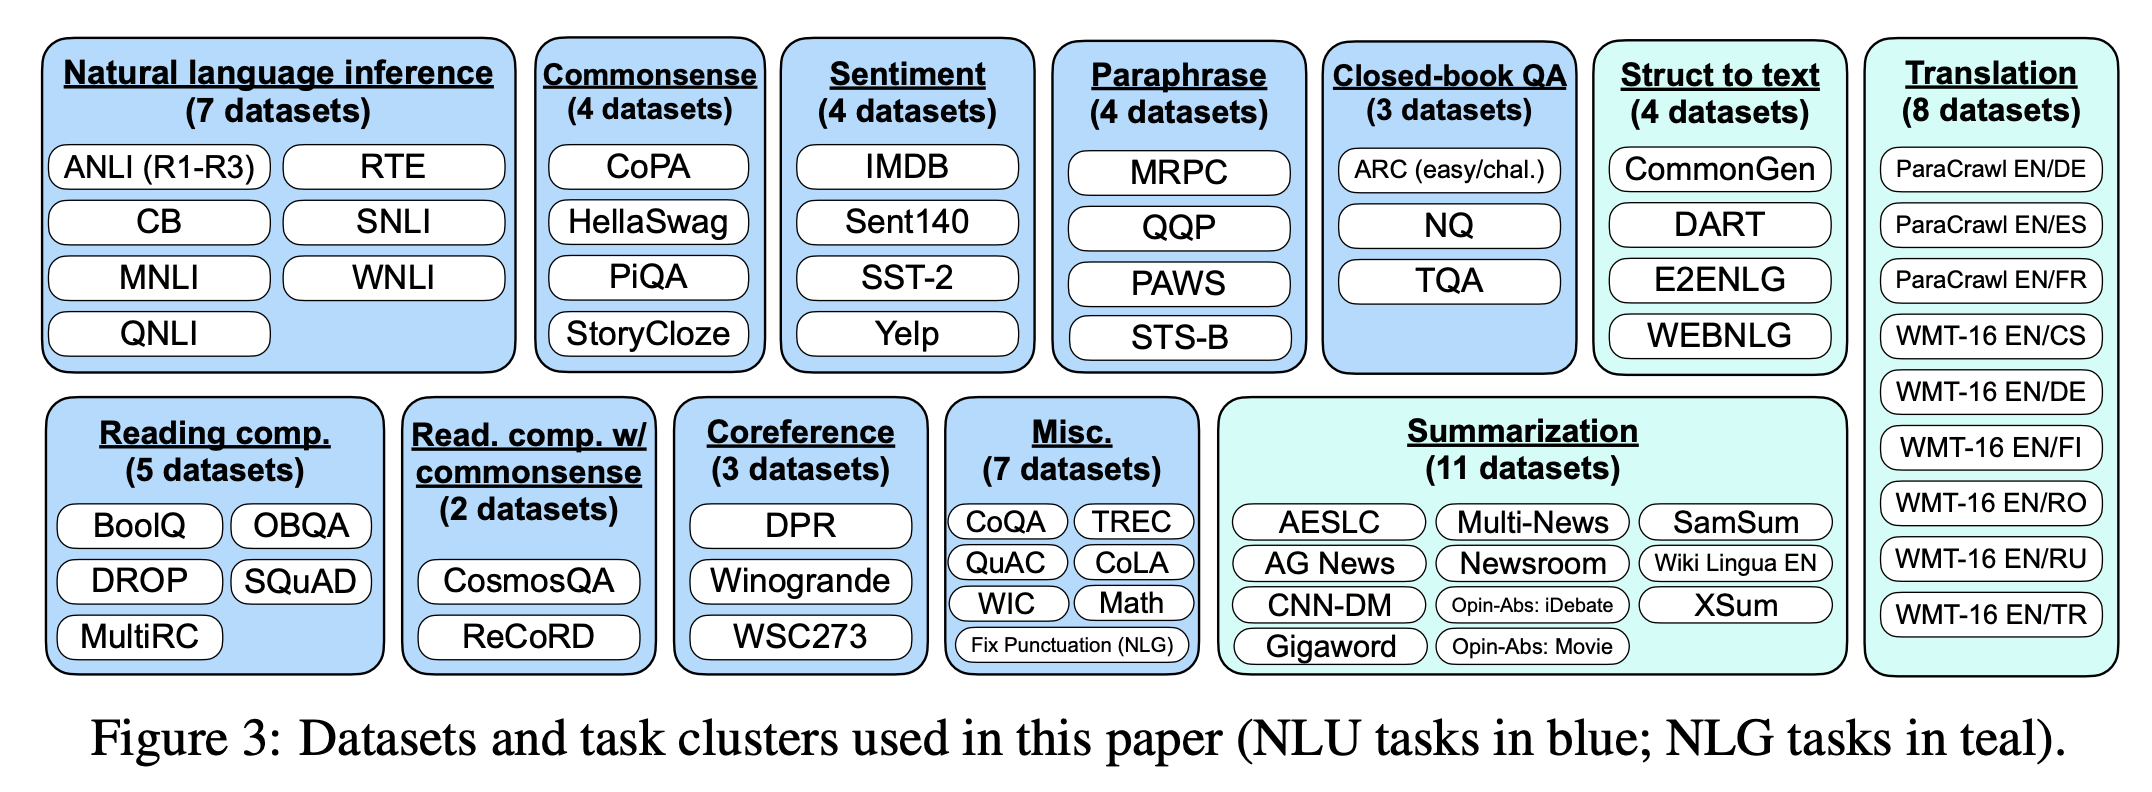

In [45]:
from IPython.display import Image, display

display(Image(filename="fig_3_from_flan_paper.png"))

OpenAI's [InstructGPT](https://arxiv.org/pdf/2203.02155.pdf) on the other hand was trained on prompts collected from their own API. They then paid workers to write completions for those prompts. Here's a breakdown of the data:

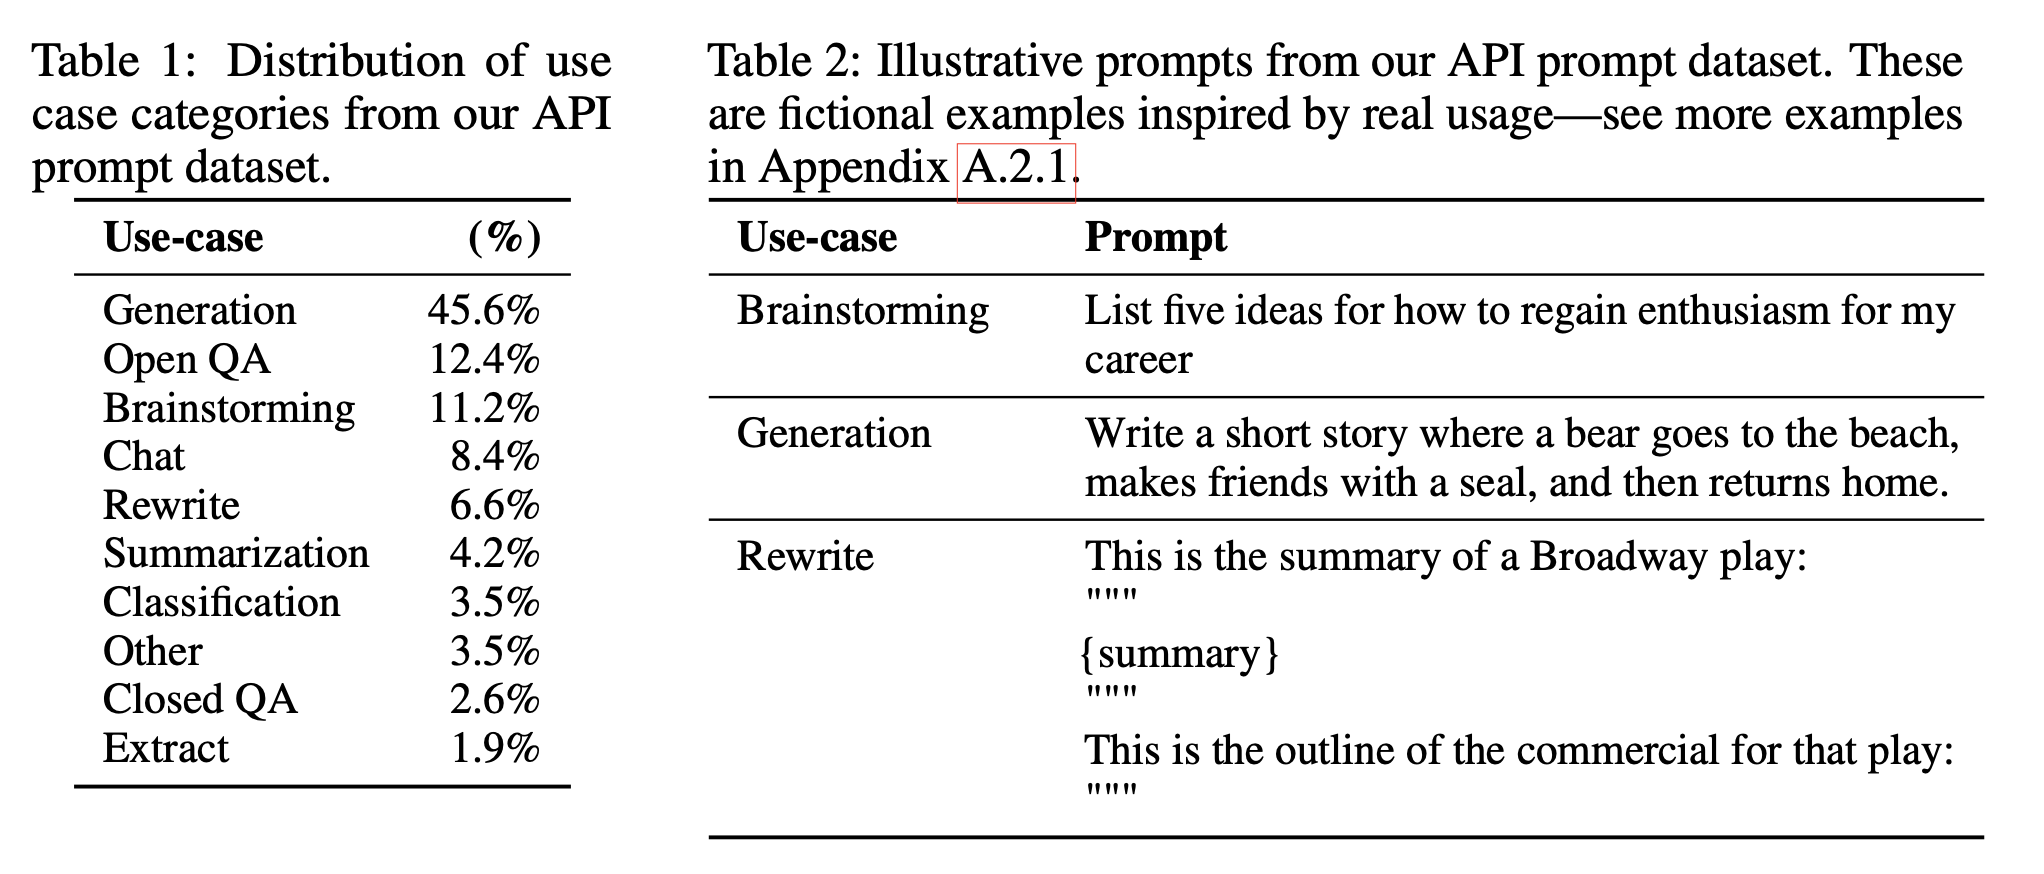

In [46]:
from IPython.display import Image, display

display(Image(filename="table_1_and_2_from_instructgpt_paper.png"))

#### Parameter Efficient Fine-tuning

When we talk about fine-tuning in the above sections, it is assumed that we are updating all of the model parameters. While this yields the best performance, it is costly both in terms of compute (need to back propagate over the entire model) and in terms of storage (for each fine-tuned model, you need to store a completely new copy of the parameters). For instruction fine-tuning, this is fine, we want maximum performance, but if you then wanted to fine-tune 100 different models for various downstream tasks, then you'd have a problem. The most simple approach to this problem is to only update the head and freeze (i.e. make untrainable) the rest of the model. This would speed up training and greatly reduce the number of new parameters, however it would not perform nearly as well as a full fine-tune (we are lacking the deep in deep learning). We could instead selectively freeze specific layers (i.e. freeze all layers except the last 4, or freeze every other layer, or freeze all parameters except multi-head attention parameters), which would help restore some of the depth. This will perform a lot better, but we become a lot less parameter efficient and reduce our training speed ups. Instead, we can utilize parameter-efficient fine-tuning (PEFT) methods. PEFT is active area of research, and there are [lots](https://aclanthology.org/2021.emnlp-main.243.pdf) [of](https://arxiv.org/pdf/2110.07602.pdf) [different](https://arxiv.org/pdf/2101.00190.pdf) [methods](https://arxiv.org/pdf/2103.10385.pdf) [to](https://arxiv.org/pdf/2106.09685.pdf) [choose](https://arxiv.org/pdf/1902.00751.pdf) [from](https://arxiv.org/abs/2205.05638). As an example, take the [Adapters paper](https://arxiv.org/pdf/1902.00751.pdf). In this approach, we add an additional "adapter" layer after the FFN and MHA layers in the transformer block. The adapter layer is just a simple 2 layer fully connected **nn**, where the input and output dimensions are `n_embd`, and the hidden dimension is smaller than `n_embd`:

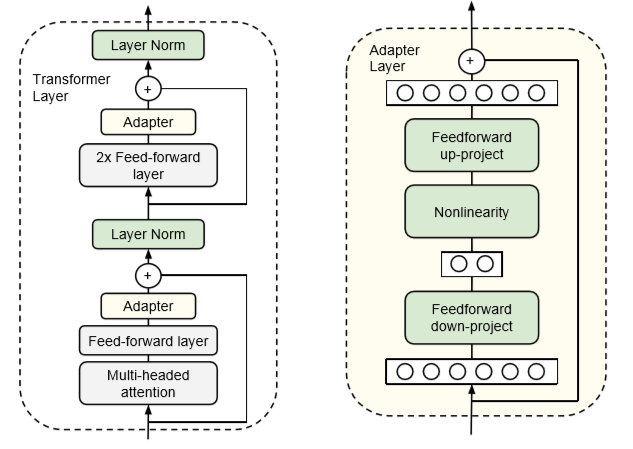

In [47]:
from IPython.display import Image, display

display(Image(filename="fig_2_from_the_adapters_paper.png"))